In [3]:
import glob
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from pymutspec.annotation.spectra import get_cossim, complete_sbs192_columns, collapse_sbs192
from pymutspec.annotation import CodonAnnotation, rev_comp
from pymutspec.constants import possible_sbs192, possible_sbs12, possible_codons
from pymutspec.draw import plot_mutspec192, plot_mutspec12
import pymutspec
from pymutspec.annotation import calculate_mutspec


from Bio import SeqIO
from Bio.Data import CodonTable
from scipy import spatial
from scipy.spatial.distance import cdist, pdist, squareform

import warnings
warnings.filterwarnings("ignore")

coda = CodonAnnotation(gencode=2)

## Derive species-specific spectra of mtDNA genes

### Aggregate species-specific spectra
that calculated only on variable sites (incorrect)

In [3]:
# paths12 = glob.glob('../data/chordata2/output/*/*/tables/ms12syn.tsv')
# paths192 = glob.glob('../data/chordata2/output/*/*/tables/ms192syn.tsv')

# paths_history = glob.glob('../data/chordata2/output/*/*/.nextflow/history')

# gene_species = set([x.split('/')[5] for x in paths12])

In [3]:
# total_data = []
# for lbl, paths in zip(['12', '192'], [paths12, paths192]):
#     data = []
#     for p in tqdm.tqdm(paths, f'Species-Gene {lbl}'):
#         gene, species = p.split('/')[5].split('__')
#         spectrum = pd.read_csv(p, sep='\t')
#         spectrum = spectrum.assign(Species=species, Gene=gene)
#         data.append(spectrum)
#     df = pd.concat(data)
#     total_data.append(df.copy())
#     df.to_csv(f'../data/new_dataset/raw_spectum{lbl}.csv')

Species-Gene 192: 100%|██████████| 7478/7478 [00:13<00:00, 572.17it/s]


### Calculate and save Expected mut counts with conservative sites for CytB

In [2]:
paths_msa = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/*/*/msa_nuc.fasta') 
len(paths_msa)

9252

In [3]:
def collect_exp_freqs_parallel(seq: str):
    exp12, exp192 = coda.collect_exp_mut_freqs(seq, labels=['syn'])
    return exp12['syn'], exp192['syn']


def collect_exp_parallel(seq: str):
    x = coda.collect_exp_muts(seq, labels=['syn'])
    x['Cxt'] = x['Mut'].apply(lambda x: x[0] + x[2] + x[-1])
    x = x[['Pos', 'Cxt']].drop_duplicates()
    cxt_freqs = x['Cxt'].value_counts().to_dict()
    return cxt_freqs


def calc_acgt_share(seq: str):
    n = len(seq)
    acgt = seq.count("A") + seq.count("C") + seq.count("G") + seq.count("T")
    return acgt / n

100%|██████████| 9252/9252 [00:05<00:00, 1749.62it/s]


count    9252.000000
mean       29.309230
std        38.640423
min         7.000000
25%        12.000000
50%        17.000000
75%        30.000000
max       500.000000
dtype: float64


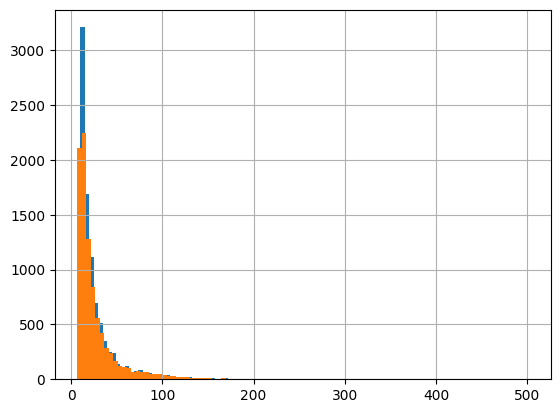

In [ ]:
# Check that number of seqs for exp computing is normal

c1, c2 = [], []
for path_fasta in tqdm.tqdm(paths_msa):
    msa = [str(r.seq) for r in list(SeqIO.parse(path_fasta, 'fasta')) if r.id != 'OUTGRP']

    # filter out partial seqs (< 80%)
    msa_flt = [x for x in msa if calc_acgt_share(x) > 0.8]
    c1.append(len(msa_flt))
    c2.append(len(msa))

print(pd.Series(c1).describe())
pd.Series(c2).hist(bins=100);
pd.Series(c1).hist(bins=100);

In [4]:
msa = [str(r.seq) for r in list(SeqIO.parse(paths_msa[10], 'fasta')) if r.id != 'OUTGRP']
collect_exp_freqs_parallel(msa[0])


p = Pool(64)
_ = p.map(collect_exp_freqs_parallel, msa)

In [27]:
# collect exp freqs
data = []
list_of_species = list()

i = 0
for path_fasta in tqdm.tqdm(paths_msa):
    i += 1
    p_elements = path_fasta.split('/')
    
    gene_species = p_elements[8]
    gene, species = gene_species.split('__')
    list_of_species.append(gene_species)

    msa = [str(r.seq) for r in list(SeqIO.parse(path_fasta, 'fasta')) if r.id != 'OUTGRP']

    # filter out partial seqs (< 80%)
    msa_flt = [x for x in msa if calc_acgt_share(x) > 0.8]
    
    # collect descriptive features
    msa_flt_nseqs = len(msa_flt)
    msa_flt_ncols = len(msa_flt[0])
    acgt_share_mean = np.mean([calc_acgt_share(x) for x in msa_flt])

    raw = p.map(collect_exp_freqs_parallel, msa_flt)

    raw_exp12  = [x[0] for x in raw]
    raw_exp192 = [x[1] for x in raw]

    nseqs = len(msa_flt)
    mean_exp = defaultdict(float)
    mean_exp['gene'] = gene
    mean_exp['species'] = species
    mean_exp['msa_nseqs'] = msa_flt_nseqs
    mean_exp['msa_ncols'] = msa_flt_ncols
    mean_exp['acgt_share'] = acgt_share_mean
    for sbs in possible_sbs12:
        for rex in raw_exp12:
            mean_exp[sbs] += rex.get(sbs, 0.) / nseqs
    for sbs in possible_sbs192:
        for rex in raw_exp192:
            mean_exp[sbs] += rex.get(sbs, 0.) / nseqs
        
    data.append(mean_exp)

    # if i >= 100:
    #     break

exp_raw_df = pd.DataFrame(data)
exp_raw_df.to_csv('../data/new_dataset/exp_num_raw.csv', index=False)

100%|██████████| 9252/9252 [02:06<00:00, 73.20it/s] 


In [28]:
exp_raw_df

,gene,species,msa_nseqs,msa_ncols,acgt_share,A>C,A>G,A>T,C>A,C>G,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,ND1,Eleotris_fusca,12,972,1.000000,86.833333,130.500000,86.833333,60.916667,60.916667,...,5.166667,3.000000,0.000000,0.083333,0.000000,1.000000,1.916667,4.250000,4.000000,3.833333
1,ND1,Lasiurus_blossevillii,10,954,1.000000,76.400000,145.300000,76.400000,38.300000,38.300000,...,3.100000,3.700000,0.500000,1.000000,1.200000,0.300000,1.500000,0.500000,0.000000,2.000000
2,ND1,Anaxyrus_fowleri,50,900,0.999911,71.960000,121.640000,71.960000,44.660000,44.660000,...,4.340000,5.980000,0.060000,0.000000,0.000000,0.000000,4.440000,6.880000,2.000000,6.060000
3,ND1,Lichanura_trivirgata,64,885,0.999735,100.578125,156.218750,100.578125,41.625000,41.625000,...,0.437500,1.015625,1.000000,0.015625,0.000000,0.062500,3.000000,2.843750,1.500000,0.093750
4,ND1,Anaxyrus_woodhousii,52,939,0.992320,79.711538,131.192308,79.711538,41.480769,41.480769,...,5.019231,5.980769,0.000000,0.000000,0.000000,0.000000,4.403846,7.019231,2.019231,6.980769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9247,ND4L,Microcebus_rufus,29,291,1.000000,17.586207,39.758621,17.586207,15.551724,15.551724,...,1.724138,2.551724,0.344828,0.103448,0.000000,1.034483,1.896552,1.068966,0.000000,0.758621
9248,ND4L,Mammuthus_primigenius,46,294,0.972124,24.130435,38.869565,24.130435,12.413043,12.413043,...,0.000000,1.021739,0.891304,0.000000,0.086957,1.021739,2.000000,2.000000,0.978261,0.000000
9249,ND4L,Macrhybopsis_aestivalis,11,261,1.000000,23.090909,40.545455,23.090909,14.000000,14.000000,...,0.909091,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000
9250,ND4L,Sciurus_anomalus,13,294,1.000000,20.307692,39.846154,20.307692,8.230769,8.230769,...,0.000000,3.692308,1.000000,0.000000,0.000000,0.000000,2.000000,3.000000,2.000000,0.923077


In [5]:
# collect syn contexts freqs
data_cxt = []

i = 0
for path_fasta in tqdm.tqdm(paths_msa):
    i += 1
    p_elements = path_fasta.split('/')
    
    gene_species = p_elements[8]
    gene, species = gene_species.split('__')

    msa = [str(r.seq) for r in list(SeqIO.parse(path_fasta, 'fasta')) if r.id != 'OUTGRP']

    # filter out partial seqs (< 80%)
    msa_flt = [x for x in msa if calc_acgt_share(x) > 0.8]
    
    raw_cxt_freqs = p.map(collect_exp_parallel, msa_flt)

    nseqs = len(msa_flt)
    mean_exp = defaultdict(float)
    mean_exp['gene'] = gene
    mean_exp['species'] = species

    for cxt in possible_codons:
        for rex in raw_cxt_freqs:
            mean_exp[cxt] += rex.get(cxt, 0.) / nseqs
    
    data_cxt.append(mean_exp)
    # if i == 10:
    #     break

cxt_df = pd.DataFrame(data_cxt)
cxt_df.to_csv('../data/new_dataset/exp_cxt_freqs.csv', index=False)
cxt_df

100%|██████████| 9252/9252 [02:58<00:00, 51.84it/s] 


,gene,species,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,ND1,Eleotris_fusca,6.000000,7.916667,6.916667,2.000000,4.000000,9.000000,7.416667,11.916667,...,6.000000,9.333333,2.166667,3.250000,0.916667,3.083333,6.833333,8.000000,6.000000,20.666667
1,ND1,Lasiurus_blossevillii,3.300000,4.600000,5.000000,4.000000,4.100000,4.900000,3.300000,14.700000,...,2.100000,8.500000,2.900000,2.300000,2.600000,3.300000,13.500000,2.400000,6.300000,12.100000
2,ND1,Anaxyrus_fowleri,4.960000,6.200000,6.000000,4.800000,2.340000,5.400000,2.780000,7.200000,...,3.360000,7.340000,3.000000,0.960000,2.000000,1.400000,14.740000,21.600000,7.680000,21.880000
3,ND1,Lichanura_trivirgata,4.000000,9.953125,4.109375,4.656250,6.875000,10.109375,2.953125,10.875000,...,5.203125,8.078125,0.125000,3.015625,1.750000,2.078125,9.312500,3.234375,2.593750,1.265625
4,ND1,Anaxyrus_woodhousii,5.000000,6.019231,5.980769,4.980769,2.000000,6.000000,3.000000,10.461538,...,2.961538,7.346154,3.807692,1.076923,1.115385,2.942308,15.269231,20.423077,8.019231,23.826923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9247,ND4L,Microcebus_rufus,1.000000,0.103448,1.965517,1.965517,2.310345,0.758621,0.000000,6.206897,...,1.896552,2.068966,0.137931,1.310345,0.413793,0.172414,6.448276,3.206897,1.137931,4.586207
9248,ND4L,Mammuthus_primigenius,0.956522,0.000000,1.978261,0.000000,1.826087,2.760870,1.934783,9.130435,...,2.043478,2.021739,0.304348,0.869565,1.000000,1.282609,3.891304,3.000000,1.913043,2.869565
9249,ND4L,Macrhybopsis_aestivalis,1.000000,0.000000,1.909091,2.454545,0.000000,3.000000,0.000000,4.454545,...,0.000000,4.000000,0.000000,1.181818,0.000000,1.545455,2.000000,3.090909,3.000000,4.000000
9250,ND4L,Sciurus_anomalus,1.000000,0.000000,1.846154,1.000000,0.076923,2.000000,1.000000,5.230769,...,2.000000,5.000000,1.692308,1.000000,0.307692,1.000000,3.307692,5.000000,2.000000,4.846154


### Merge observed mutations tables

In [16]:
paths_observed = glob.glob('../data/chordata2/output/*/*/tables/observed_mutations.tsv')
cols_useless = ['ProbaFull', 'Gene']
data_obs = []

for p in tqdm.tqdm(paths_observed, 'Species-Gene'):
    gene, species = p.split('/')[5].split('__')
    spectrum = pd.read_csv(p, sep='\t')
    spectrum = spectrum.assign(species=species, gene=gene)\
        .drop(cols_useless, axis=1).rename(columns={'PosInGene': 'Site', 'Label': 'MutType'})
    data_obs.append(spectrum)

obs_df = pd.concat(data_obs)
obs_df.to_csv(f'../data/new_dataset/raw_obs_muts.csv', index=False)

Species-Gene: 100%|██████████| 9232/9232 [00:29<00:00, 308.23it/s]


In [18]:
obs_df

,Mut,Label,Site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,RefNode,AltNode,species,gene
0,G[A>G]C,2,150,3,GGA,GGG,G,G,0.99935,0.99935,Node1,Node2,Eleotris_fusca,ND1
1,C[T>C]T,1,154,1,TTA,CTA,L,L,0.99935,0.99935,Node1,Node2,Eleotris_fusca,ND1
2,T[C>T]A,2,267,3,CTC,CTT,L,L,0.99938,0.99938,Node1,Node2,Eleotris_fusca,ND1
3,G[T>C]G,1,474,3,AGT,AGC,S,S,0.99935,0.99935,Node1,Node2,Eleotris_fusca,ND1
4,G[G>A]C,1,555,3,TGG,TGA,W,W,0.99934,0.99934,Node1,Node2,Eleotris_fusca,ND1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,C[A>G]C,2,12,3,ACA,ACG,T,T,1.00000,1.00000,Node9,RN_4,Branchiostoma_belcheri,ND4L
34,A[C>T]G,1,192,3,CAC,CAT,H,H,1.00000,1.00000,Node7,RN_6,Branchiostoma_belcheri,ND4L
35,A[T>C]T,1,102,3,TAT,TAC,Y,Y,1.00000,1.00000,Node7,RN_9,Branchiostoma_belcheri,ND4L
36,T[G>A]T,1,126,3,TTG,TTA,L,L,1.00000,1.00000,Node8,RN_8,Branchiostoma_belcheri,ND4L


## Analysis and filtration of exp

In [2]:
exp_raw_df = pd.read_csv('../data/new_dataset/exp_num_raw.csv')
exp_raw_df

,gene,species,msa_nseqs,msa_ncols,acgt_share,A>C,A>G,A>T,C>A,C>G,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,ND1,Eleotris_fusca,12,972,1.000000,86.833333,130.500000,86.833333,60.916667,60.916667,...,5.166667,3.000000,0.000000,0.083333,0.000000,1.000000,1.916667,4.250000,4.000000,3.833333
1,ND1,Lasiurus_blossevillii,10,954,1.000000,76.400000,145.300000,76.400000,38.300000,38.300000,...,3.100000,3.700000,0.500000,1.000000,1.200000,0.300000,1.500000,0.500000,0.000000,2.000000
2,ND1,Anaxyrus_fowleri,50,900,0.999911,71.960000,121.640000,71.960000,44.660000,44.660000,...,4.340000,5.980000,0.060000,0.000000,0.000000,0.000000,4.440000,6.880000,2.000000,6.060000
3,ND1,Lichanura_trivirgata,64,885,0.999735,100.578125,156.218750,100.578125,41.625000,41.625000,...,0.437500,1.015625,1.000000,0.015625,0.000000,0.062500,3.000000,2.843750,1.500000,0.093750
4,ND1,Anaxyrus_woodhousii,52,939,0.992320,79.711538,131.192308,79.711538,41.480769,41.480769,...,5.019231,5.980769,0.000000,0.000000,0.000000,0.000000,4.403846,7.019231,2.019231,6.980769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9247,ND4L,Microcebus_rufus,29,291,1.000000,17.586207,39.758621,17.586207,15.551724,15.551724,...,1.724138,2.551724,0.344828,0.103448,0.000000,1.034483,1.896552,1.068966,0.000000,0.758621
9248,ND4L,Mammuthus_primigenius,46,294,0.972124,24.130435,38.869565,24.130435,12.413043,12.413043,...,0.000000,1.021739,0.891304,0.000000,0.086957,1.021739,2.000000,2.000000,0.978261,0.000000
9249,ND4L,Macrhybopsis_aestivalis,11,261,1.000000,23.090909,40.545455,23.090909,14.000000,14.000000,...,0.909091,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000
9250,ND4L,Sciurus_anomalus,13,294,1.000000,20.307692,39.846154,20.307692,8.230769,8.230769,...,0.000000,3.692308,1.000000,0.000000,0.000000,0.000000,2.000000,3.000000,2.000000,0.923077


In [3]:
# acgt_share is normal (>0.95)
exp_raw_df.groupby('gene').acgt_share.describe()

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
A6,487.0,0.998118,0.005428,0.944786,0.998848,0.999944,1.0,1.0
A8,183.0,0.995098,0.008072,0.959566,0.993600,0.999167,1.0,1.0
CO1,1011.0,0.999375,0.001680,0.982821,0.999577,1.000000,1.0,1.0
CO2,237.0,0.998395,0.004503,0.968632,0.999435,1.000000,1.0,1.0
CO3,246.0,0.999013,0.002311,0.985125,0.999402,1.000000,1.0,1.0
Cytb,3218.0,0.998628,0.002823,0.963201,0.998461,0.999836,1.0,1.0
ND1,403.0,0.998360,0.004175,0.959742,0.998986,0.999970,1.0,1.0
ND2,1823.0,0.996567,0.005912,0.950530,0.995346,0.999514,1.0,1.0
ND3,233.0,0.997420,0.006359,0.945336,0.998545,1.000000,1.0,1.0


In [4]:
# msa_nseqs is normal (>=7)
exp_raw_df.groupby('gene').msa_nseqs.describe()

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
A6,487.0,26.589322,31.845688,9.0,13.0,17.0,29.00,500.0
A8,183.0,19.928962,36.177681,7.0,11.0,13.0,20.00,484.0
CO1,1011.0,22.427300,34.118422,8.0,10.0,14.0,22.00,500.0
CO2,237.0,22.481013,35.491892,9.0,12.0,15.0,22.00,488.0
CO3,246.0,25.504065,39.776185,9.0,12.0,15.0,23.75,499.0
Cytb,3218.0,32.912057,40.536724,9.0,12.0,19.0,36.00,499.0
ND1,403.0,29.074442,38.819834,9.0,12.0,18.0,30.00,490.0
ND2,1823.0,30.968733,39.014642,8.0,12.0,19.0,33.00,467.0
ND3,233.0,22.124464,32.669676,9.0,11.0,14.0,23.00,467.0


In [6]:
_gene_order = [
    'Cytb', 'ND2', 'CO1', 'CO3',
    'ND5', 'ND4', 'ND4L', 
    'ND3',  'A6', 'A8', 'CO2',
    'ND1', 'ND6', 
]

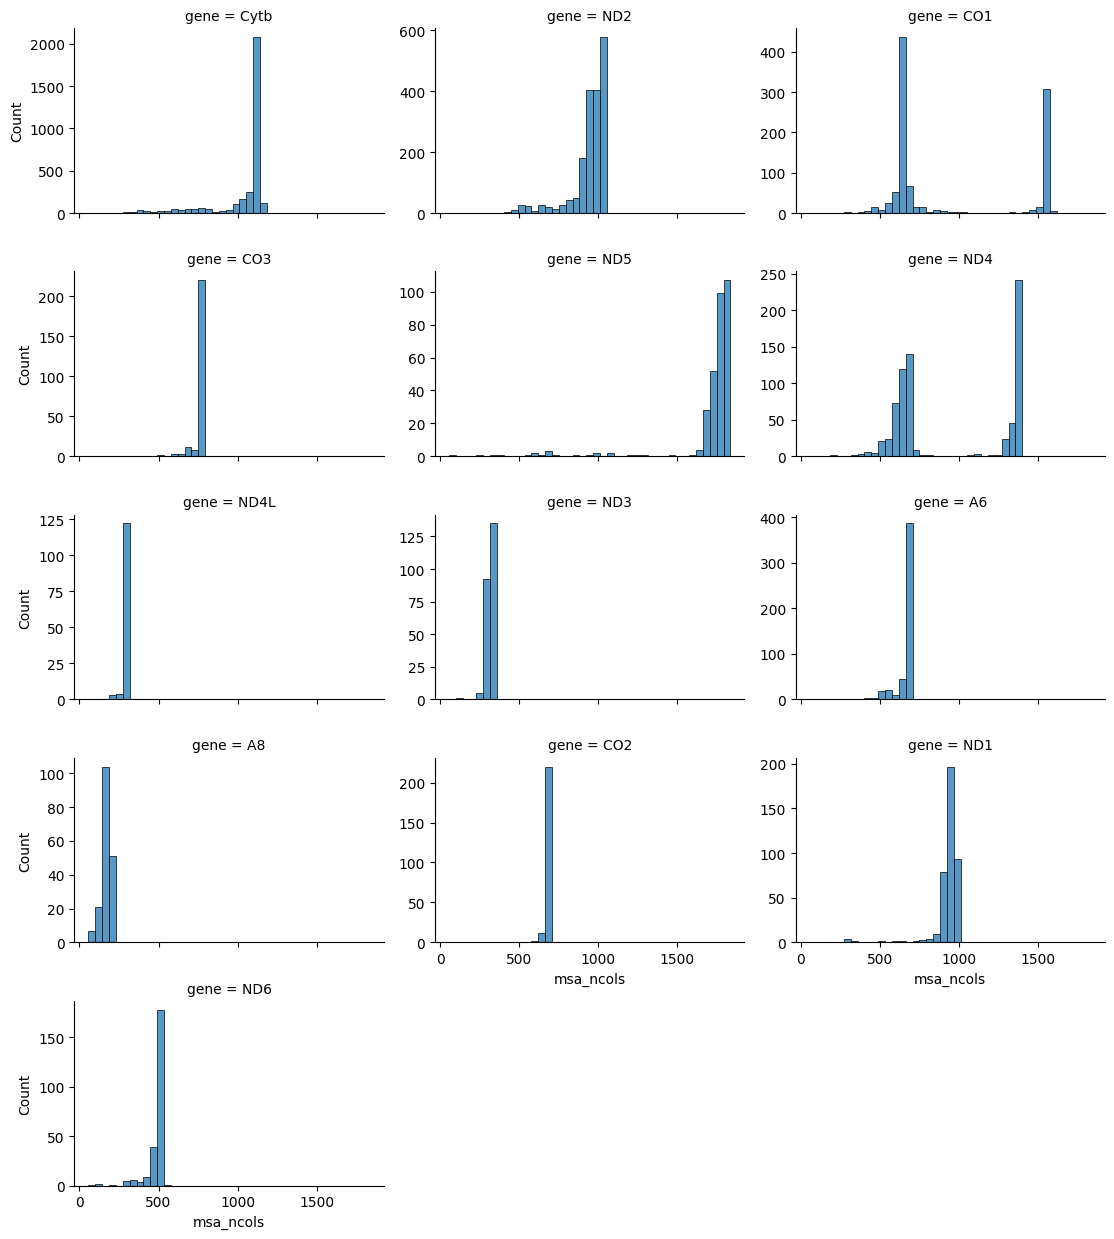

In [64]:
g = sns.displot(data=exp_raw_df, x='msa_ncols', col='gene', col_order=_gene_order,
            height=2.5, aspect=1.5, col_wrap=3, kind='hist', facet_kws={'sharey': False})
g.savefig('../pictures/new_dataset_msa_ncols_distributions.pdf')

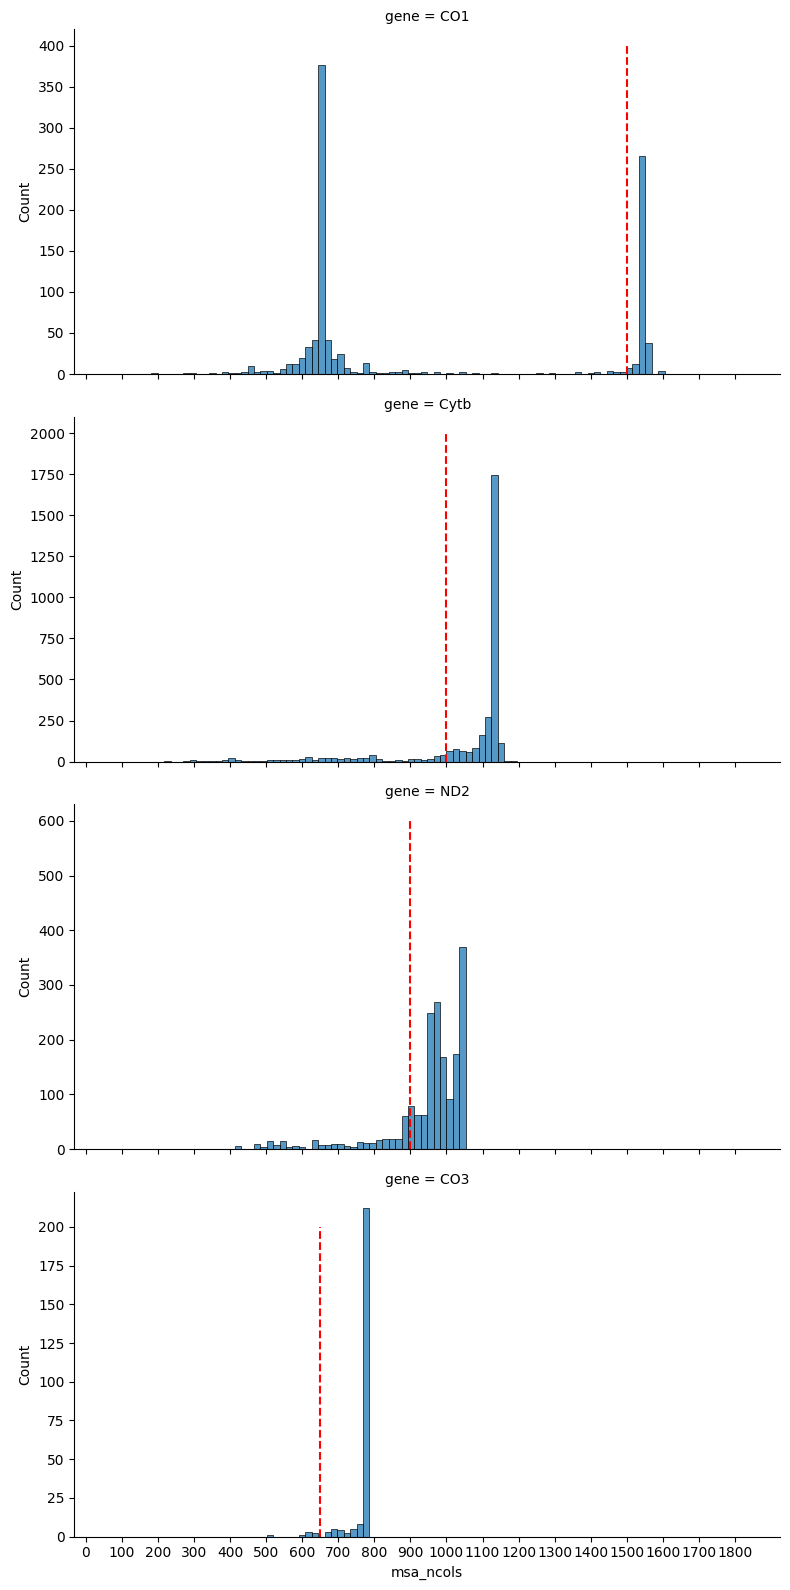

In [60]:
# msa ncols cutoffs:
cutoff_CO1  = 1500
cutoff_Cytb = 1000
cutoff_ND2  = 900
cutoff_CO3  = 650

g = sns.displot(data=exp_raw_df, x='msa_ncols', col='gene', col_order=['CO1', 'Cytb', 'ND2', 'CO3'],
            height=4, aspect=2, col_wrap=1, kind='hist', facet_kws={'sharey': False}, bins=100)
g.axes_dict['CO1'].set_xticks(np.arange(0, 1801, 100))
g.axes_dict['CO1'].vlines(cutoff_CO1, 0, 400, 'red', '--')
g.axes_dict['Cytb'].vlines(cutoff_Cytb, 0, 2000, 'red', '--')
g.axes_dict['ND2'].vlines(cutoff_ND2, 0, 600, 'red', '--')
g.axes_dict['CO3'].vlines(cutoff_CO3, 0, 200, 'red', '--')
plt.show()

In [12]:
exp_raw_df.groupby('gene').msa_ncols.describe()

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
A6,487.0,659.605749,52.683118,255.0,672.00,678.0,681.0,792.0
A8,183.0,165.327869,28.910275,57.0,153.00,165.0,189.0,204.0
CO1,1011.0,953.008902,425.200844,186.0,651.00,657.0,1542.0,1599.0
CO2,237.0,678.734177,24.812368,351.0,681.00,681.0,684.0,732.0
CO3,246.0,771.109756,35.969717,519.0,783.00,783.0,783.0,786.0
Cytb,3218.0,1047.768179,180.784435,234.0,1065.00,1137.0,1140.0,1194.0
ND1,403.0,922.756824,106.201842,261.0,909.00,954.0,966.0,978.0
ND2,1823.0,947.165661,119.419176,282.0,933.00,972.0,1032.0,1053.0
ND3,233.0,319.763948,31.852977,135.0,288.00,339.0,345.0,351.0


### Filter dataset

Select 4 main genes and species that have nearly full sequence

In [65]:
# # msa ncols cutoffs:
# cutoff_CO1  = 1500
# cutoff_Cytb = 1000
# cutoff_ND2  = 900
# cutoff_CO3  = 650

sel_exp_genes = pd.concat([
    exp_raw_df[(exp_raw_df.gene == 'CO1') & (exp_raw_df.msa_ncols > cutoff_CO1)],
    exp_raw_df[(exp_raw_df.gene == 'Cytb') & (exp_raw_df.msa_ncols > cutoff_Cytb)],
    exp_raw_df[(exp_raw_df.gene == 'ND2') & (exp_raw_df.msa_ncols > cutoff_ND2)],
    exp_raw_df[(exp_raw_df.gene == 'CO3') & (exp_raw_df.msa_ncols > cutoff_CO3)],
])
print('Number of used species for selected genes')
sel_exp_genes.gene.value_counts()

Number of used species for selected genes


Cytb    2650
ND2     1479
CO1      325
CO3      239
Name: gene, dtype: int64

In [69]:
sel_exp_genes

,gene,species,msa_nseqs,msa_ncols,acgt_share,A>C,A>G,A>T,C>A,C>G,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
2474,CO1,Crocuta_crocuta,15,1542,0.999741,115.066667,173.333333,115.066667,71.466667,71.466667,...,15.133333,9.800000,4.866667,1.133333,4.666667,4.400000,4.400000,5.066667,1.933333,2.066667
2475,CO1,Neodon_sikimensis,11,1542,0.999823,132.181818,204.090909,132.181818,75.454545,75.454545,...,8.181818,3.272727,3.727273,1.545455,2.181818,0.181818,6.454545,5.727273,4.272727,3.727273
2476,CO1,Homo_sapiens,499,1539,0.999939,114.446894,183.314629,114.446894,97.278557,97.278557,...,12.016032,3.010020,1.997996,0.967936,2.987976,3.012024,2.887776,2.955912,1.012024,2.032064
2477,CO1,Eothenomys_melanogaster,21,1539,0.999598,128.285714,199.333333,128.285714,77.904762,77.904762,...,6.238095,2.761905,2.190476,1.000000,2.333333,2.000000,6.000000,4.904762,1.000000,3.714286
2479,CO1,Geomys_arenarius,12,1530,1.000000,117.166667,188.583333,117.166667,39.333333,39.333333,...,13.500000,9.666667,8.666667,1.333333,2.916667,3.666667,7.750000,5.000000,4.000000,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7358,CO3,Ateles_chamek,10,783,1.000000,62.200000,106.800000,62.200000,41.900000,41.900000,...,3.000000,1.000000,0.900000,2.200000,1.000000,0.000000,1.000000,2.200000,0.900000,0.000000
7359,CO3,Melospiza_lincolnii,12,756,1.000000,59.916667,100.916667,59.916667,62.416667,62.416667,...,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,2.000000,0.000000
7360,CO3,Symposiachrus_guttula,12,783,1.000000,71.416667,108.166667,71.416667,40.916667,40.916667,...,3.833333,2.000000,0.083333,0.166667,1.000000,0.000000,2.000000,1.833333,2.750000,0.000000
7361,CO3,Eopsaltria_australis,14,783,1.000000,68.071429,103.714286,68.071429,44.071429,44.071429,...,3.000000,1.571429,0.000000,1.142857,0.000000,1.571429,2.428571,2.571429,2.071429,1.000000


### add class labels

In [107]:
taxinfo = pd.read_csv('../data/chordata2/info.csv')
taxinfo['species'] = taxinfo['species'].str.replace(' ', '_')
taxinfo['class'] = taxinfo['taxa'].apply(lambda x: '_'.join(x.split(';')[1].split('_')[:-1]))
taxinfo.head()

,acc,gene,taxa,species,class
0,AB478558.1.8820.9502_BAH86124.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_belcheri,Leptocardii
1,AB478590.1.8806.9488_BAH86540.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_floridae,Leptocardii
2,Y09525.1.238.>921_CAA70712.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_lanceolatum,Leptocardii
3,KP722183.1.159.>838_AJV90905.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_fluviatilis,Hyperoartia
4,FR669668.2.1432.>2101_CBW30998.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_planeri,Hyperoartia


In [108]:
sel_exp_genes_cls = sel_exp_genes.merge(taxinfo.drop(['acc', 'taxa'], axis=1), on=['species', 'gene'])
sel_exp_genes_cls['class'].value_counts()

Mammalia                   1567
Actinopteri                1223
Aves                       1005
Lepidosauria                528
Amphibia                    251
Chondrichthyes               46
class_Testudines             36
class_Crocodylia             14
Leptocardii                  12
Hyperoartia                   7
class_Ceratodontiformes       2
Cladistia                     2
Name: class, dtype: int64

In [109]:
sel_exp_genes_cls = sel_exp_genes_cls[sel_exp_genes_cls['class'].isin(sel_exp_genes_cls['class'].value_counts().index[:5])]

In [110]:
sel_exp_genes_cls['class'].value_counts()

Mammalia        1567
Actinopteri     1223
Aves            1005
Lepidosauria     528
Amphibia         251
Name: class, dtype: int64

In [112]:
sel_exp_genes_cls.to_csv('../data/new_dataset/expected.csv', index=False)

## Obs analysis and filtration

In [3]:
expected = pd.read_csv('../data/new_dataset/expected.csv')
expected

,gene,species,msa_nseqs,msa_ncols,acgt_share,A>C,A>G,A>T,C>A,C>G,...,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T,class
0,CO1,Crocuta_crocuta,15,1542,0.999741,115.066667,173.333333,115.066667,71.466667,71.466667,...,9.800000,4.866667,1.133333,4.666667,4.400000,4.400000,5.066667,1.933333,2.066667,Mammalia
1,CO1,Neodon_sikimensis,11,1542,0.999823,132.181818,204.090909,132.181818,75.454545,75.454545,...,3.272727,3.727273,1.545455,2.181818,0.181818,6.454545,5.727273,4.272727,3.727273,Mammalia
2,CO1,Homo_sapiens,499,1539,0.999939,114.446894,183.314629,114.446894,97.278557,97.278557,...,3.010020,1.997996,0.967936,2.987976,3.012024,2.887776,2.955912,1.012024,2.032064,Mammalia
3,CO1,Eothenomys_melanogaster,21,1539,0.999598,128.285714,199.333333,128.285714,77.904762,77.904762,...,2.761905,2.190476,1.000000,2.333333,2.000000,6.000000,4.904762,1.000000,3.714286,Mammalia
4,CO1,Geomys_arenarius,12,1530,1.000000,117.166667,188.583333,117.166667,39.333333,39.333333,...,9.666667,8.666667,1.333333,2.916667,3.666667,7.750000,5.000000,4.000000,8.000000,Mammalia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4569,CO3,Ateles_chamek,10,783,1.000000,62.200000,106.800000,62.200000,41.900000,41.900000,...,1.000000,0.900000,2.200000,1.000000,0.000000,1.000000,2.200000,0.900000,0.000000,Mammalia
4570,CO3,Melospiza_lincolnii,12,756,1.000000,59.916667,100.916667,59.916667,62.416667,62.416667,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,2.000000,0.000000,Aves
4571,CO3,Symposiachrus_guttula,12,783,1.000000,71.416667,108.166667,71.416667,40.916667,40.916667,...,2.000000,0.083333,0.166667,1.000000,0.000000,2.000000,1.833333,2.750000,0.000000,Aves
4572,CO3,Eopsaltria_australis,14,783,1.000000,68.071429,103.714286,68.071429,44.071429,44.071429,...,1.571429,0.000000,1.142857,0.000000,1.571429,2.428571,2.571429,2.071429,1.000000,Aves


In [4]:
obs_df = pd.read_csv('../data/new_dataset/raw_obs_muts.csv')
obs_df = obs_df.merge(expected[['gene', 'species', 'class']], 
                      on=['gene', 'species'])
obs_df_syn = obs_df[obs_df.MutType > 0]
obs_df_syn

,Mut,MutType,Site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,RefNode,AltNode,species,gene,class
0,A[C>T]C,1,54,3,AAC,AAT,N,N,0.301658,0.301658,Node1,Node2,Pica_pica,ND2,Aves
1,A[T>C]T,1,57,3,CAT,CAC,H,H,0.317493,0.317493,Node1,Node2,Pica_pica,ND2,Aves
2,T[T>C]A,2,63,3,GTT,GTC,V,V,0.316240,0.316240,Node1,Node2,Pica_pica,ND2,Aves
3,C[C>T]C,2,132,3,CCC,CCT,P,P,0.303806,0.303806,Node1,Node2,Pica_pica,ND2,Aves
4,T[T>C]G,2,141,3,GTT,GTC,V,V,0.315447,0.315447,Node1,Node2,Pica_pica,ND2,Aves
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725070,A[A>G]T,1,342,3,GAA,GAG,E,E,1.000000,1.000000,Node7,Node8,Hyla_meridionalis,CO3,Amphibia
725071,A[C>T]C,1,693,3,CAC,CAT,H,H,1.000000,1.000000,Node7,Node8,Hyla_meridionalis,CO3,Amphibia
725072,T[T>C]G,1,699,3,TTT,TTC,F,F,1.000000,1.000000,Node7,Node8,Hyla_meridionalis,CO3,Amphibia
725073,T[C>T]C,2,150,3,CTC,CTT,L,L,0.999990,0.999990,Node7,RN_4,Hyla_meridionalis,CO3,Amphibia


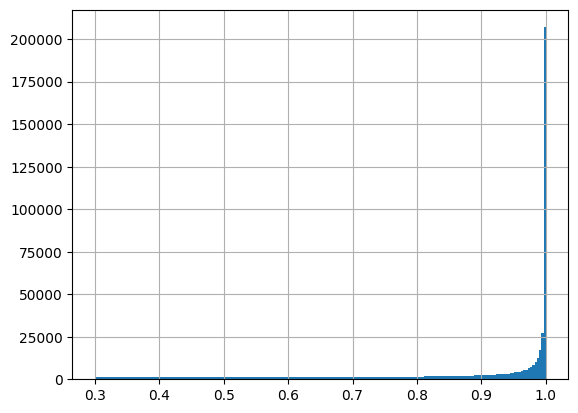

In [192]:
obs_df_syn.ProbaRef.hist(bins=200);

### Filter out outlier tree edges

In [209]:
edge_nobs = obs_df_syn.groupby(['gene', 'species', 'AltNode']).ProbaMut.sum().rename('edge_nobs')
edge_nobs_df = edge_nobs.reset_index()
edge_nobs_df.groupby('gene').describe().round(2)

edge_nobs                                          
         count  mean   std   min  25%  50%   75%     max
gene                                                    
CO1     9535.0  3.55  8.55  0.32  1.0  1.0  2.00  148.38
CO3     5146.0  2.37  4.33  0.30  1.0  1.0  2.00   74.00
Cytb   87917.0  3.49  6.89  0.30  1.0  1.0  2.99  246.47
ND2    42638.0  3.50  6.06  0.30  1.0  1.0  3.00  113.93

In [169]:
def get_iqr_bounds(series: pd.Series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound


def filter_outliers(data, column=None, max_val=None):
    if isinstance(column, str) and isinstance(data, pd.DataFrame):
        series = data[column]
    elif isinstance(data, pd.Series):
        series = data
    else:
        raise Exception('incorrect input')

    _, upper_bound = get_iqr_bounds(series)
    filtered_data = data[(series <= upper_bound)]
    if max_val:
        filtered_data = filtered_data[(filtered_data[column] <= max_val)]
    return filtered_data

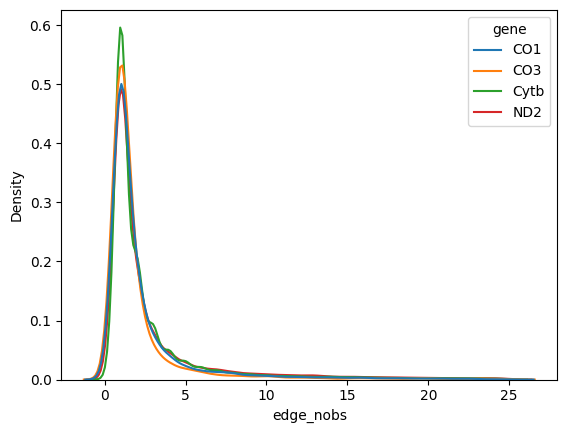

In [211]:
sns.kdeplot(data=edge_nobs_df[edge_nobs_df.edge_nobs<25], 
            x='edge_nobs', hue='gene', common_norm=False);

In [212]:
get_iqr_bounds(edge_nobs_df.edge_nobs)

(-1.9822075000000003, 5.9702925)

In [213]:
edge_nobs_df_flt = filter_outliers(edge_nobs_df, 'edge_nobs')
edge_nobs_df_flt.groupby('gene').describe().round(2)

edge_nobs                                        
         count  mean   std   min  25%  50%   75%   max
gene                                                  
CO1     8515.0  1.58  1.03  0.32  1.0  1.0  2.00  5.97
CO3     4794.0  1.46  0.95  0.30  1.0  1.0  1.96  5.96
Cytb   77398.0  1.70  1.12  0.30  1.0  1.0  2.00  5.97
ND2    36873.0  1.67  1.12  0.30  1.0  1.0  2.00  5.97

In [214]:
edge_nobs_df_flt

,gene,species,AltNode,edge_nobs
0,CO1,Alburnus_derjugini,Node10,0.998460
1,CO1,Alburnus_derjugini,Node3,0.999990
2,CO1,Alburnus_derjugini,Node5,1.000000
3,CO1,Alburnus_derjugini,Node6,0.999910
4,CO1,Alburnus_derjugini,Node7,0.999980
...,...,...,...,...
145231,ND2,Zosterops_palpebrosus,RN_34,4.815302
145232,ND2,Zosterops_palpebrosus,RN_35,3.000000
145233,ND2,Zosterops_palpebrosus,RN_5,3.995390
145234,ND2,Zosterops_palpebrosus,RN_8,0.997600


In [226]:
edge_nobs[edge_nobs >= 6].sum(), edge_nobs[edge_nobs < 6].sum()

(284519.67845999997, 217713.42414000002)

In [228]:
obs_df_syn.shape, obs_df_syn['ProbaMut'].sum().round(2)

((613804, 15), 502233.1)

In [229]:
obs_df_syn_edge_flt = obs_df_syn.merge(edge_nobs_df_flt, on=['gene', 'species', 'AltNode'])
obs_df_syn_edge_flt.shape, obs_df_syn_edge_flt['ProbaMut'].sum().round(2)

((228345, 16), 213507.6)

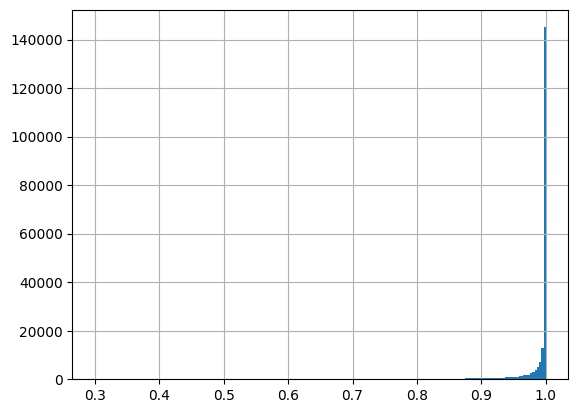

In [230]:
obs_df_syn_edge_flt.ProbaRef.hist(bins=200);

### Filter out by nobs for species

In [275]:
NOBS_CUTOFF = 20  # required at least such number of mutations for each species
nobs = obs_df_syn_edge_flt.groupby(['gene', 'species']).ProbaMut.sum().rename('nobs')
nobs_flt = nobs[nobs >= NOBS_CUTOFF]
nobs_flt_df = nobs_flt.reset_index()
print(nobs.shape, nobs_flt.shape)
nobs_flt.sum(level=0)

(4570,) (3026,)


gene
CO1      12029.945070
CO3       5517.843605
Cytb    120897.602216
ND2      54745.975603
Name: nobs, dtype: float64

In [276]:
nobs.reset_index().groupby('gene').nobs.describe().round(2)

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
CO1,314.0,42.86,57.57,2.88,17.98,27.98,45.90,632.36
CO3,234.0,29.87,37.45,3.00,13.00,20.24,33.71,443.90
Cytb,2589.0,50.73,62.81,1.00,17.58,30.15,57.92,661.12
ND2,1433.0,43.07,62.00,1.00,15.81,25.79,46.18,852.60


In [277]:
nobs_flt_df.groupby('gene').nobs.describe().round(2)

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
CO1,213.0,56.48,65.62,20.88,27.38,35.49,57.82,632.36
CO3,119.0,46.37,46.81,20.09,24.91,33.69,50.33,443.90
Cytb,1794.0,67.39,69.15,20.01,28.91,42.75,76.56,661.12
ND2,900.0,60.83,72.54,20.03,27.56,38.01,68.10,852.60


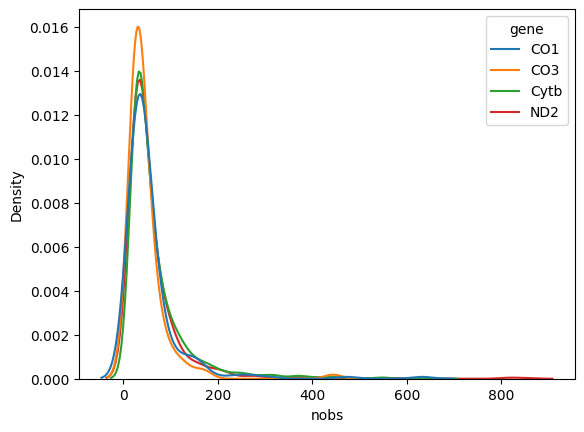

In [278]:
sns.kdeplot(data=nobs_flt_df, x='nobs', hue='gene', common_norm=False);

### Filer out by num of muttypes

In [285]:
NMUTTYPE_CUTOFF = 10
nmuttype = obs_df_syn_edge_flt.groupby(['gene', 'species']).Mut.nunique().rename('nmuttype')
nmuttype_flt = nmuttype[nmuttype > NMUTTYPE_CUTOFF]
nmuttype_df = nmuttype.reset_index()
print(nmuttype.shape)
nmuttype_df.groupby('gene').nmuttype.describe()

(4570,)


,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
CO1,314.0,25.245223,13.847425,3.0,16.0,22.0,31.0,92.0
CO3,234.0,19.952991,11.260948,2.0,12.0,17.5,25.0,72.0
Cytb,2589.0,27.172267,15.763676,1.0,15.0,23.0,36.0,98.0
ND2,1433.0,24.772505,15.134127,1.0,14.0,21.0,32.0,104.0


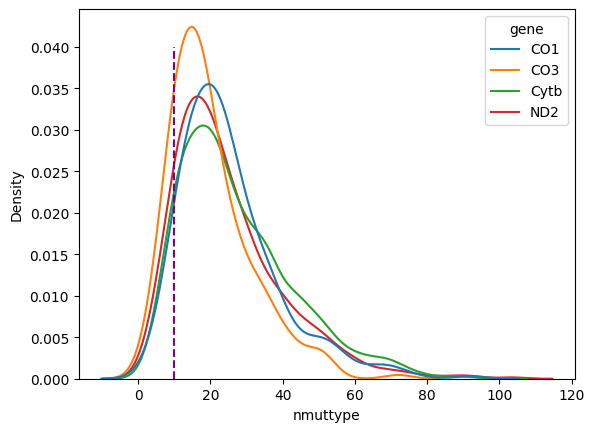

In [253]:
sns.kdeplot(data=nmuttype_df, x='nmuttype', hue='gene', common_norm=False)
plt.vlines(10, 0, 0.04, 'purple', '--', label='cutoff')
plt.show()

In [258]:
NMUTTYPE_CUTOFF = 10
ts = [x for x in possible_sbs192 if x[2:5] in ['C>T', 'T>C', 'G>A', 'A>G',]]

n_ts =  obs_df_syn_edge_flt[obs_df_syn_edge_flt.Mut.isin(ts)]\
    .groupby(['gene', 'species']).Mut.nunique().rename('n_ts')

n_ts_df = n_ts.reset_index()
print(n_ts.shape)
n_ts_df.groupby('gene').n_ts.describe()

(4570,)


,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
CO1,314.0,22.334395,11.173035,3.0,14.0,20.0,28.0,59.0
CO3,234.0,17.978632,9.575293,2.0,11.0,16.0,23.0,54.0
Cytb,2589.0,23.225570,12.292800,1.0,14.0,21.0,31.0,62.0
ND2,1433.0,21.323098,11.663143,1.0,13.0,19.0,28.0,61.0


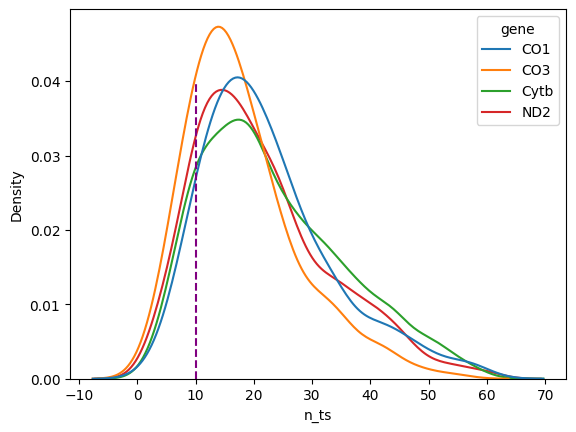

In [259]:
sns.kdeplot(data=n_ts_df, x='n_ts', hue='gene', common_norm=False)
plt.vlines(10, 0, 0.04, 'purple', '--', label='cutoff')
plt.show()

In [264]:
n_ts[n_ts > 10].shape, n_ts[n_ts <= 10].shape

((3869,), (701,))

In [266]:
nmuttype[nmuttype > 10].shape, nmuttype[nmuttype <= 10].shape

((4031,), (539,))

### Save obs muts table

In [282]:
obs_df_syn_edge_flt.shape

(228345, 16)

In [284]:
obs_df_syn_edge_flt.merge(
    nobs_flt_df.rename(columns={'nobs': 'species_nobs'}), 
    on=['gene', 'species']).shape

(206473, 17)

In [319]:
NOBS_CUTOFF = 20
NTS_CUTOFF  = 16
obs_df_syn_edge_flt_nobs_flt = obs_df_syn_edge_flt.merge(
        nobs[nobs >= NOBS_CUTOFF].reset_index().rename(columns={'nobs': 'species_nobs'}), 
        on=['gene', 'species'],
    ).merge(
        n_ts[n_ts >= NTS_CUTOFF].reset_index().rename(columns={'n_ts': 'species_n_ts'}), 
        on=['gene', 'species'],
    )
obs_df_syn_edge_flt_nobs_flt.shape

(202764, 18)

In [322]:
obs_df_syn_edge_flt_nobs_flt.groupby(['gene', 'class']).species.nunique().unstack()

class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
gene,,,,,
CO1,44,13,29,8,112
CO3,23,7,8,4,71
Cytb,525,76,130,177,794
ND2,103,86,345,190,126


In [8]:
obs_df_syn_edge_flt_nobs_flt.groupby(['gene', 'class']).ProbaMut.sum().round().unstack()

class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
gene,,,,,
CO1,2924.0,857.0,1155.0,306.0,6629.0
CO3,802.0,194.0,306.0,133.0,3949.0
Cytb,35934.0,6124.0,6043.0,13736.0,56943.0
ND2,5678.0,5612.0,16657.0,18333.0,7319.0


### Obs ts/tv ratio analysis 

In [6]:
ts = [x for x in possible_sbs192 if x[2:5] in ['C>T', 'T>C', 'G>A', 'A>G',]]

In [7]:
obs_df_syn_edge_flt_nobs_flt['is_ts'] = obs_df_syn_edge_flt_nobs_flt.Mut.isin(ts)
obs_df_syn_edge_flt_nobs_flt

,Mut,MutType,Site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,RefNode,AltNode,species,gene,class,edge_nobs,species_nobs,species_n_ts,is_ts
0,A[C>T]C,1,54,3,AAC,AAT,N,N,0.301658,0.301658,Node1,Node2,Pica_pica,ND2,Aves,2.888788,55.307859,33,True
1,A[T>C]T,1,57,3,CAT,CAC,H,H,0.317493,0.317493,Node1,Node2,Pica_pica,ND2,Aves,2.888788,55.307859,33,True
2,T[T>C]A,2,63,3,GTT,GTC,V,V,0.316240,0.316240,Node1,Node2,Pica_pica,ND2,Aves,2.888788,55.307859,33,True
3,C[C>T]C,2,132,3,CCC,CCT,P,P,0.303806,0.303806,Node1,Node2,Pica_pica,ND2,Aves,2.888788,55.307859,33,True
4,T[T>C]G,2,141,3,GTT,GTC,V,V,0.315447,0.315447,Node1,Node2,Pica_pica,ND2,Aves,2.888788,55.307859,33,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202759,C[T>A]C,2,327,3,ACT,ACA,T,T,0.600700,0.600700,Node11,RN_9,Cottus_gulosus,CO3,Actinopteri,0.904790,27.985789,22,False
202760,A[T>C]C,1,375,3,GAT,GAC,D,D,0.997170,0.997130,Node7,Node8,Cottus_gulosus,CO3,Actinopteri,0.997130,27.985789,22,True
202761,A[G>A]T,1,114,3,CAG,CAA,Q,Q,0.997950,0.997950,Node7,RN_4,Cottus_gulosus,CO3,Actinopteri,0.997950,27.985789,22,True
202762,C[A>G]A,2,312,3,GCA,GCG,A,A,1.000000,1.000000,Node12,RN_3,Cottus_gulosus,CO3,Actinopteri,1.000000,27.985789,22,True


In [18]:
ts_frac = obs_df_syn_edge_flt_nobs_flt\
    .groupby(['class', 'gene', 'species']).is_ts\
        .value_counts(normalize=True).unstack()[True].rename('ts_frac')
ts_frac

class        gene  species                 
Actinopteri  CO1   Anarhichas_lupus            0.866667
                   Anguilla_anguilla           0.839080
                   Anguilla_rostrata           0.971429
                   Boreogadus_saida            0.914894
                   Carassius_auratus           0.925000
                                                 ...   
Mammalia     ND2   Tylonycteris_pachypus       0.964286
                   Urocyon_cinereoargenteus    0.979592
                   Ursus_arctos                0.965217
                   Ursus_thibetanus            1.000000
                   Ziphius_cavirostris         0.891892
Name: ts_frac, Length: 2871, dtype: float64

In [19]:
print('Ts mean share')
ts_frac.mean(level=[0,1]).unstack()

Ts mean share


gene,CO1,CO3,Cytb,ND2
class,,,,
Actinopteri,0.894597,0.899462,0.897919,0.895080
Amphibia,0.921396,0.870456,0.907695,0.907008
Aves,0.932993,0.954114,0.930726,0.927748
Lepidosauria,0.873550,0.897476,0.899256,0.884810
Mammalia,0.943675,0.945537,0.926191,0.954041


In [12]:
# same on unfiltered obs mut dataset
obs_df_syn['is_ts'] = obs_df_syn.Mut.isin(ts)
print('Ts mean share (unfiltered dataset)')
obs_df_syn.groupby(['class', 'gene', 'species']).is_ts\
        .value_counts(normalize=True).unstack()\
            .mean(level=[0,1])[True].unstack()

Ts mean share (unfiltered dataset)


gene,CO1,CO3,Cytb,ND2
class,,,,
Actinopteri,0.885648,0.882902,0.887116,0.880943
Amphibia,0.920622,0.911779,0.896248,0.889906
Aves,0.924925,0.934711,0.912445,0.928080
Lepidosauria,0.841215,0.880573,0.886405,0.862675
Mammalia,0.942480,0.944807,0.921534,0.944374


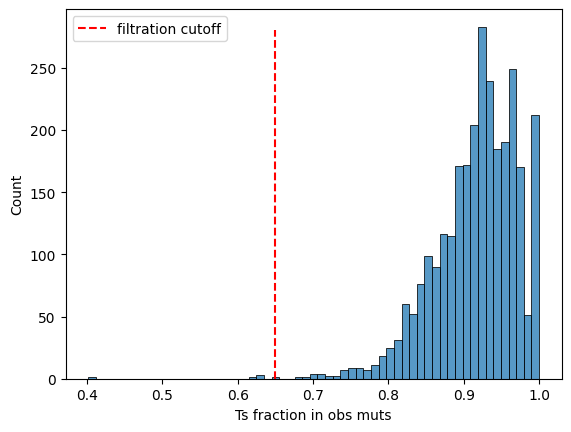

In [94]:
# sns.kdeplot(obs_df_syn.groupby(['class', 'gene', 'species']).is_ts\
#         .value_counts(normalize=True).unstack()[True])
sns.histplot(ts_frac).set_xlabel('Ts fraction in obs muts')
plt.vlines(0.65, 0, 280, 'r', '--', label='filtration cutoff')
plt.legend()
plt.show()

In [111]:
final_obs = obs_df_syn_edge_flt_nobs_flt.merge(
    ts_frac[ts_frac > 0.65].reset_index(), 
    on=['class', 'gene', 'species'])
obs_df_syn_edge_flt_nobs_flt.shape, final_obs.shape

((202764, 19), (202342, 20))

In [112]:
final_obs.to_csv('../data/new_dataset/obs_muts.csv', index=False)

#### Explore outlayers

In [105]:
ts_frac[ts_frac.between(0., 0.75)].sort_values().reset_index()

,class,gene,species,ts_frac
0,Actinopteri,Cytb,Odontobutis_potamophila,0.401639
1,Mammalia,Cytb,Tlacuatzin_canescens,0.616667
2,Mammalia,Cytb,Nelsonia_goldmani,0.625000
3,Actinopteri,Cytb,Tor_putitora,0.628205
4,Mammalia,Cytb,Cavia_porcellus,0.629630
5,Actinopteri,Cytb,Amphilius_jacksonii,0.653846
6,Actinopteri,Cytb,Oncorhynchus_mykiss,0.675676
7,Lepidosauria,Cytb,Lepidophyma_sylvaticum,0.687500
8,Lepidosauria,ND2,Crotalus_oreganus,0.696970
9,Lepidosauria,ND2,Hemidactylus_mabouia,0.697674


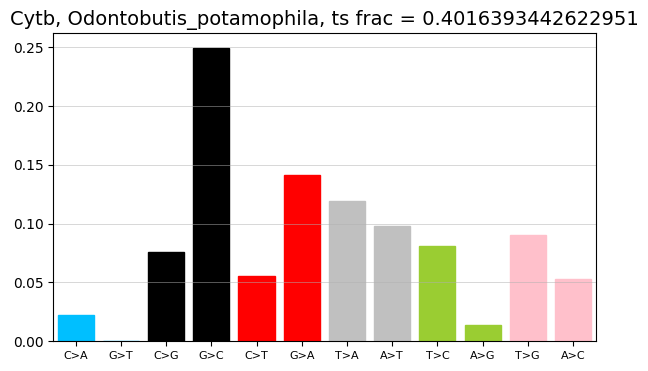

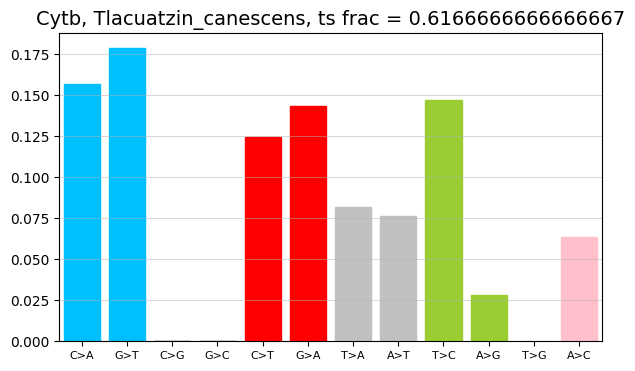

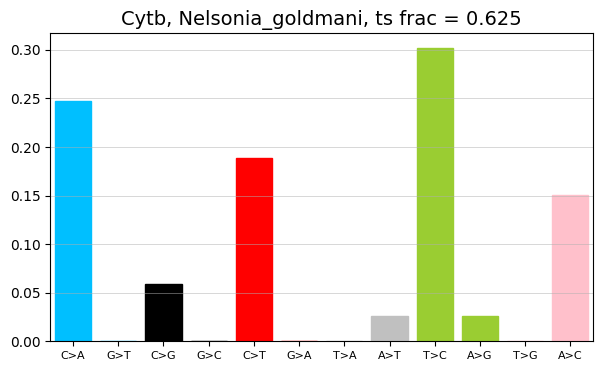

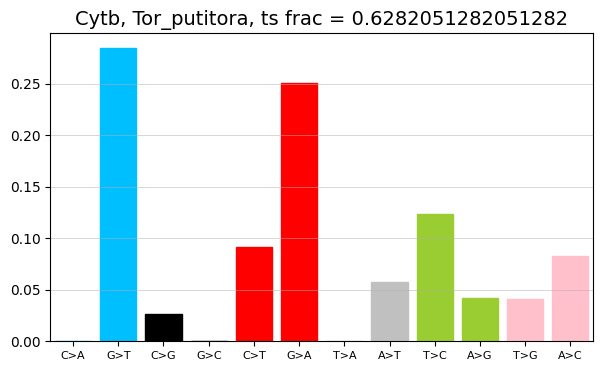

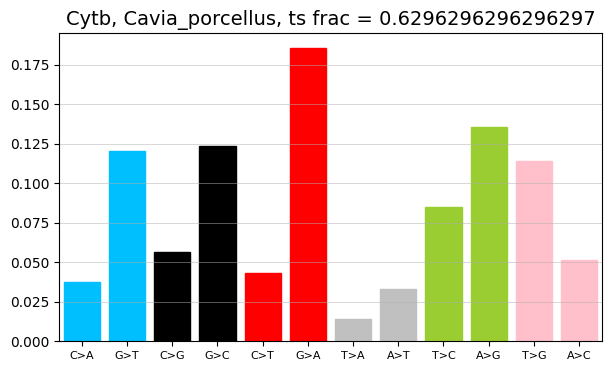

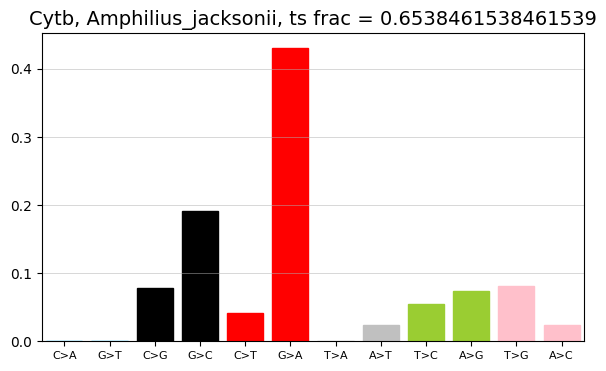

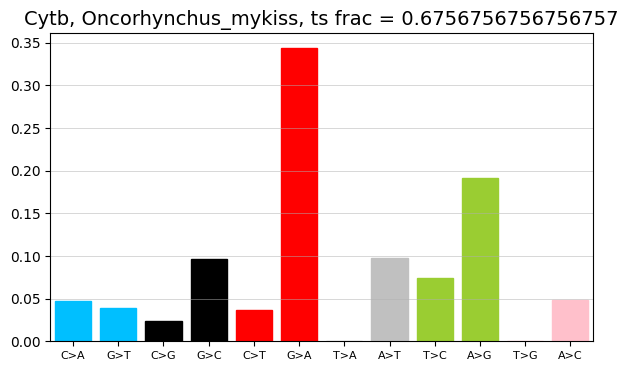

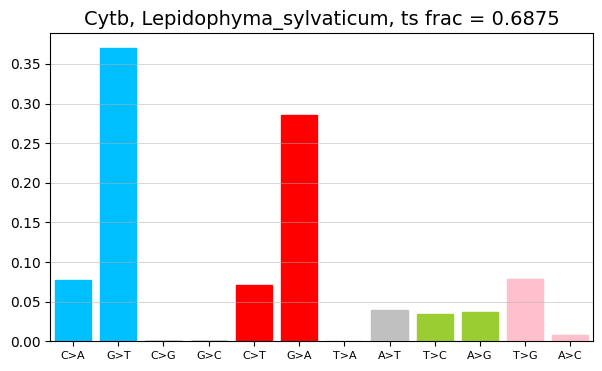

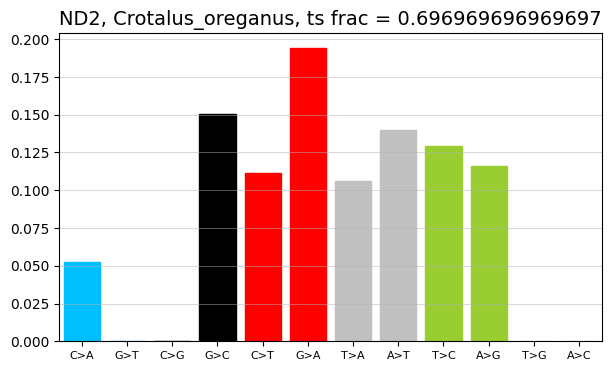

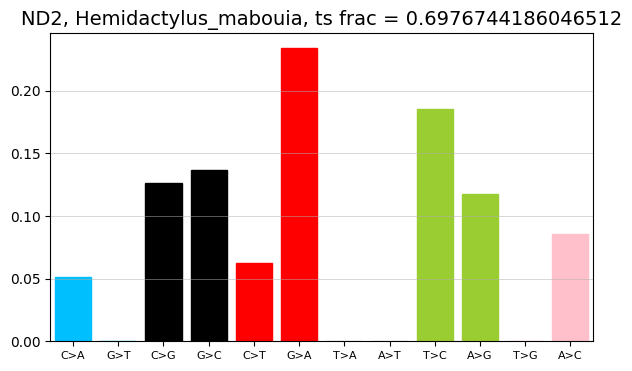

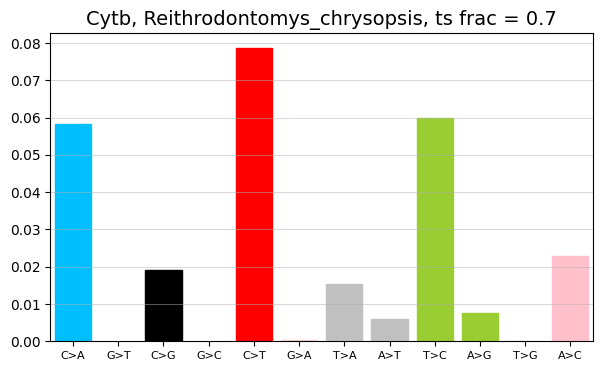

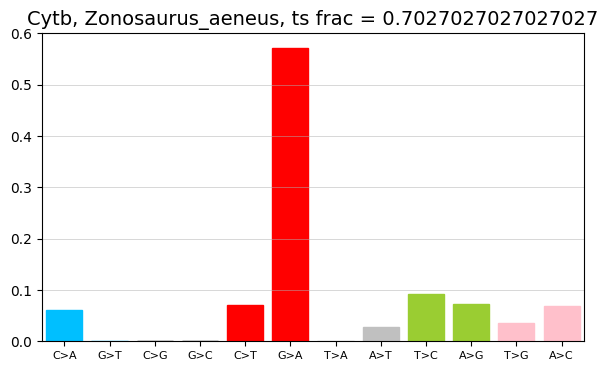

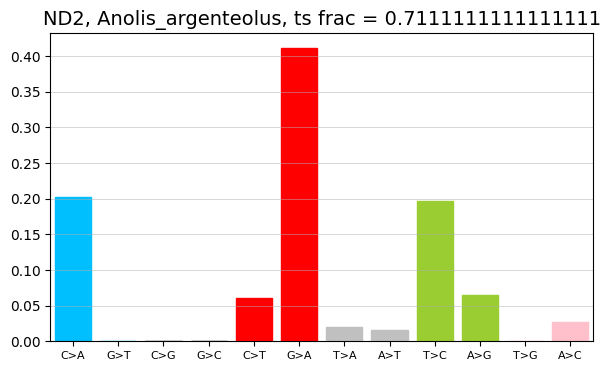

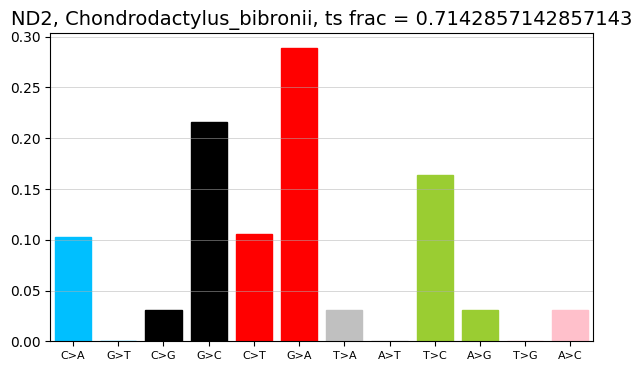

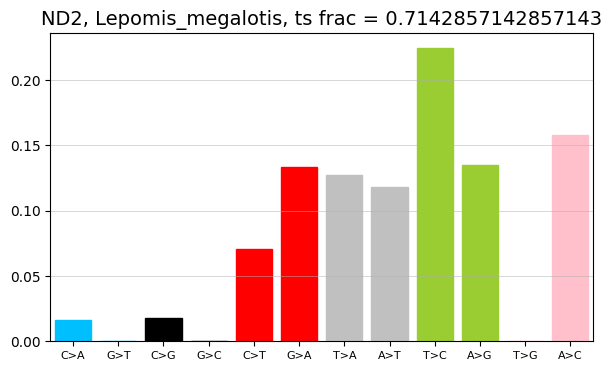

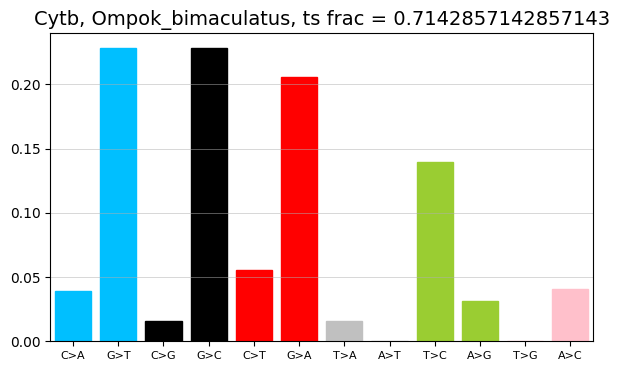

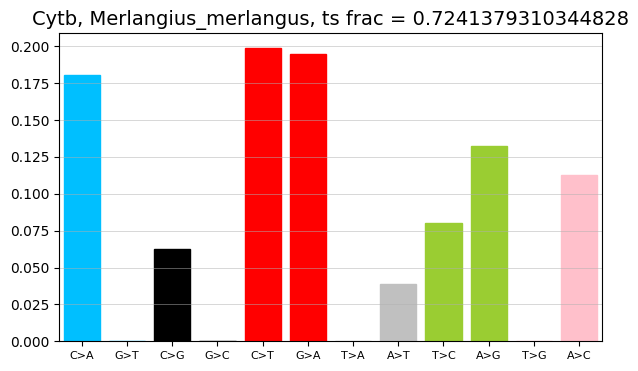

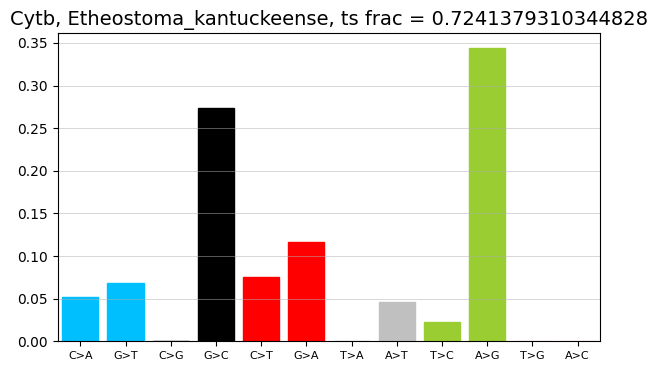

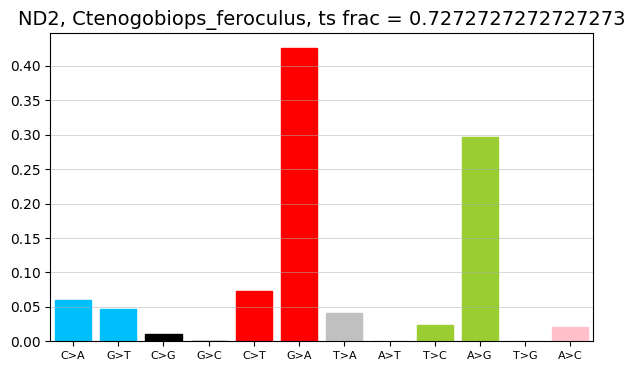

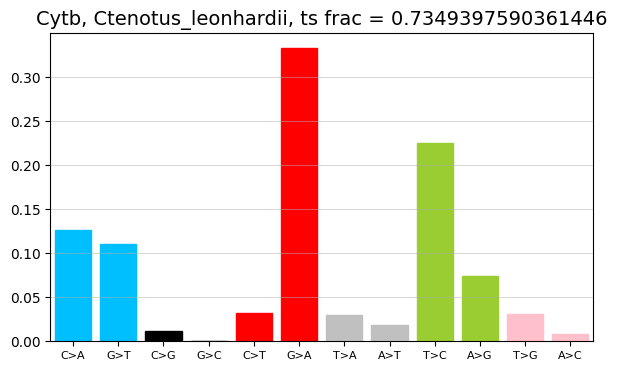

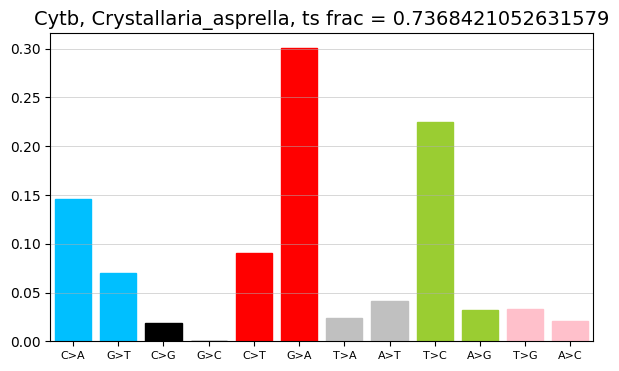

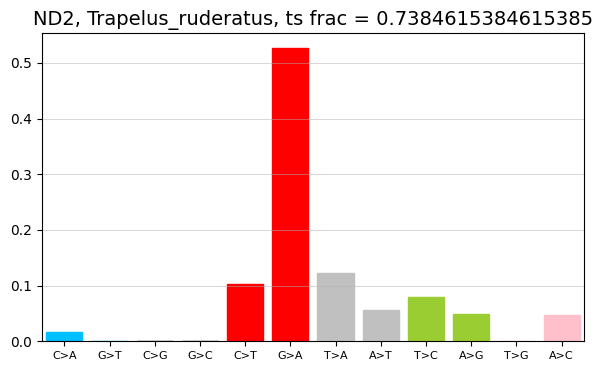

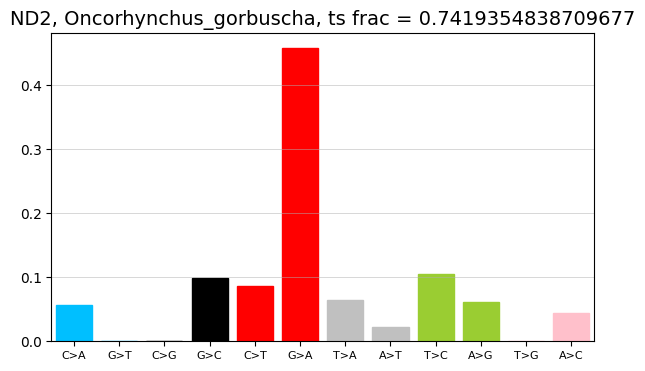

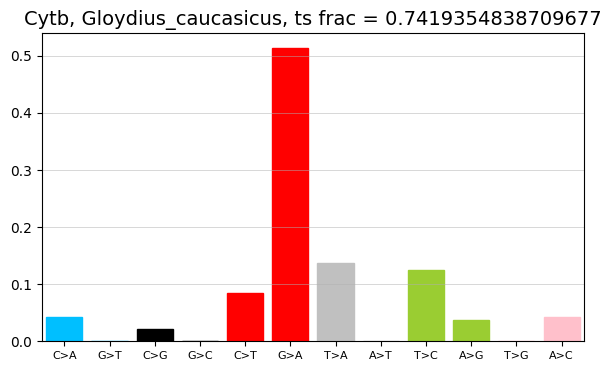

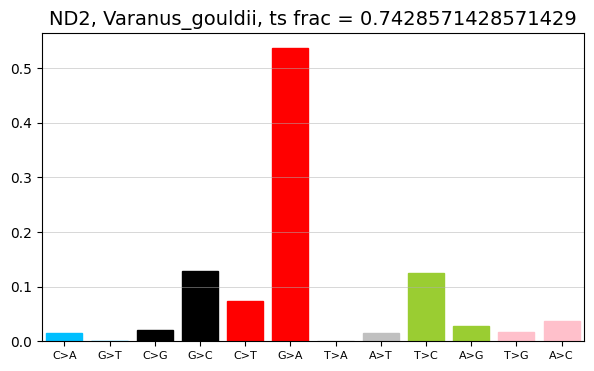

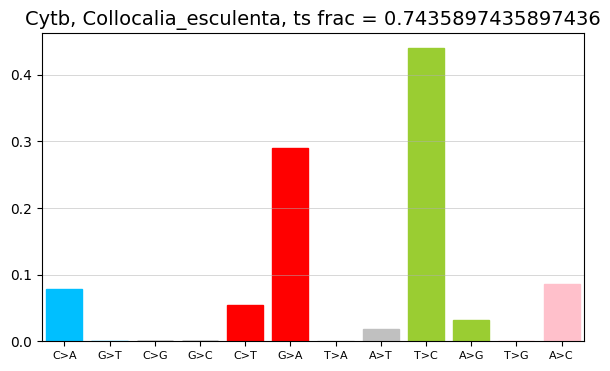

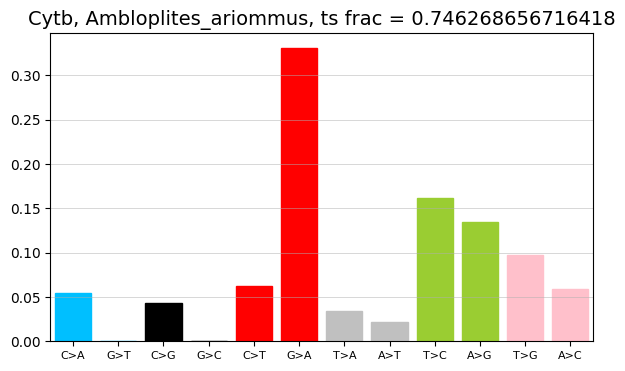

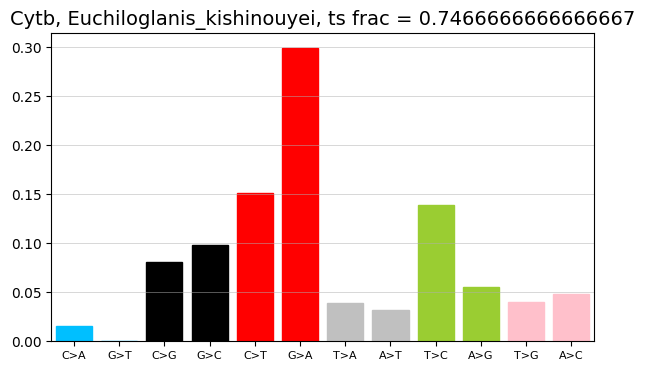

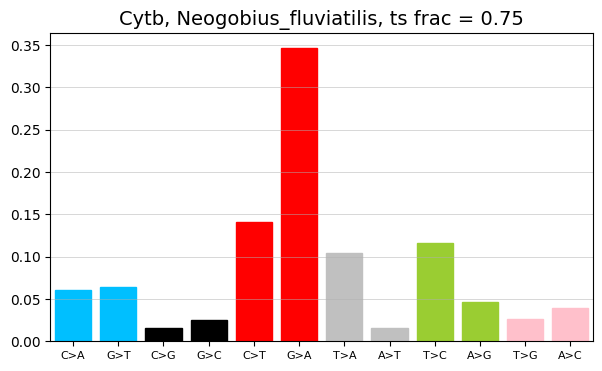

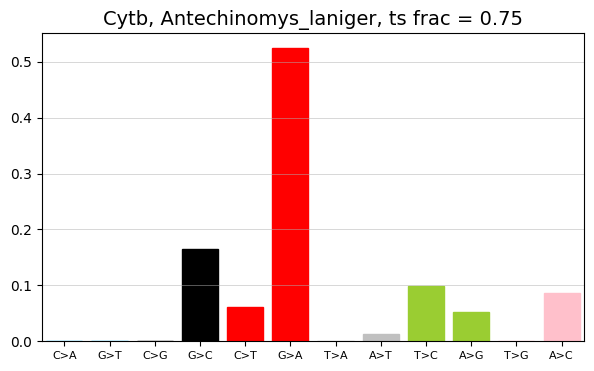

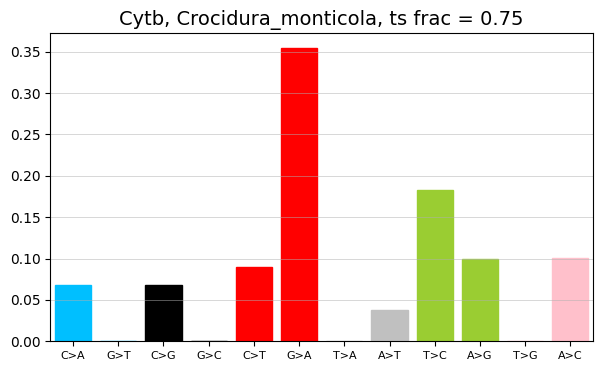

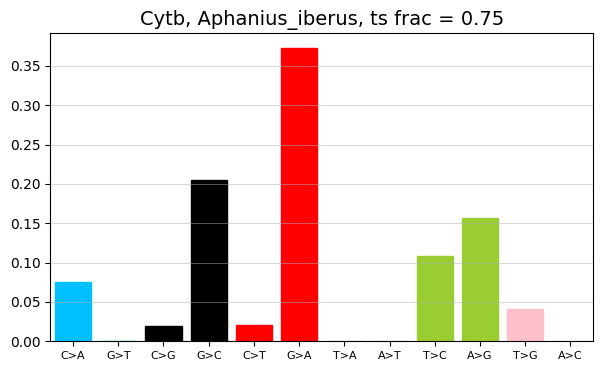

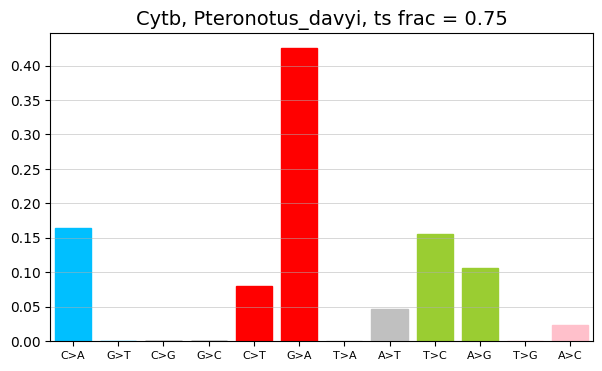

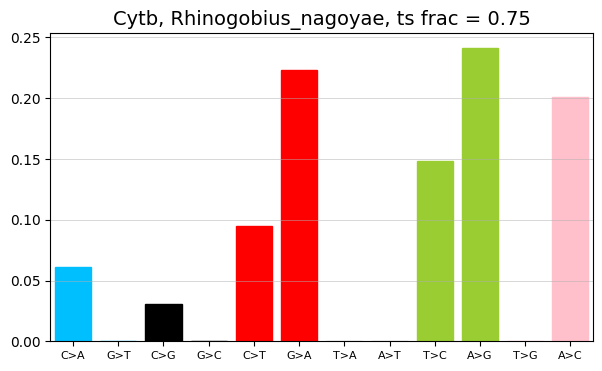

In [95]:
for i, x in ts_frac[ts_frac.between(0., 0.75)].sort_values().reset_index().iterrows():
    o = obs_df_syn_edge_flt_nobs_flt[
        (obs_df_syn_edge_flt_nobs_flt.species == x['species']) &
        (obs_df_syn_edge_flt_nobs_flt.gene == x['gene'])
    ]
    o = o.rename(columns={'ProbaMut': 'ProbaFull'})
    assert o.gene.nunique() == 1
    e = expected[
        (expected.species == x['species']) & 
        (expected.gene == x['gene'])
    ]
    e12  = e[possible_sbs12].reset_index(drop=True).T[0].to_dict()
    ms12 = calculate_mutspec(o, e12, use_proba=True)
    # e192 = e[possible_sbs192].reset_index(drop=True).T[0].to_dict()
    # ms192 = calculate_mutspec(o, e192, True, True)

    plot_mutspec12(
        ms12[ms12.ExpNum > 1], figsize=(7, 4),
        title=f"{x['gene']}, {x['species']}, ts frac = {x['ts_frac']}");

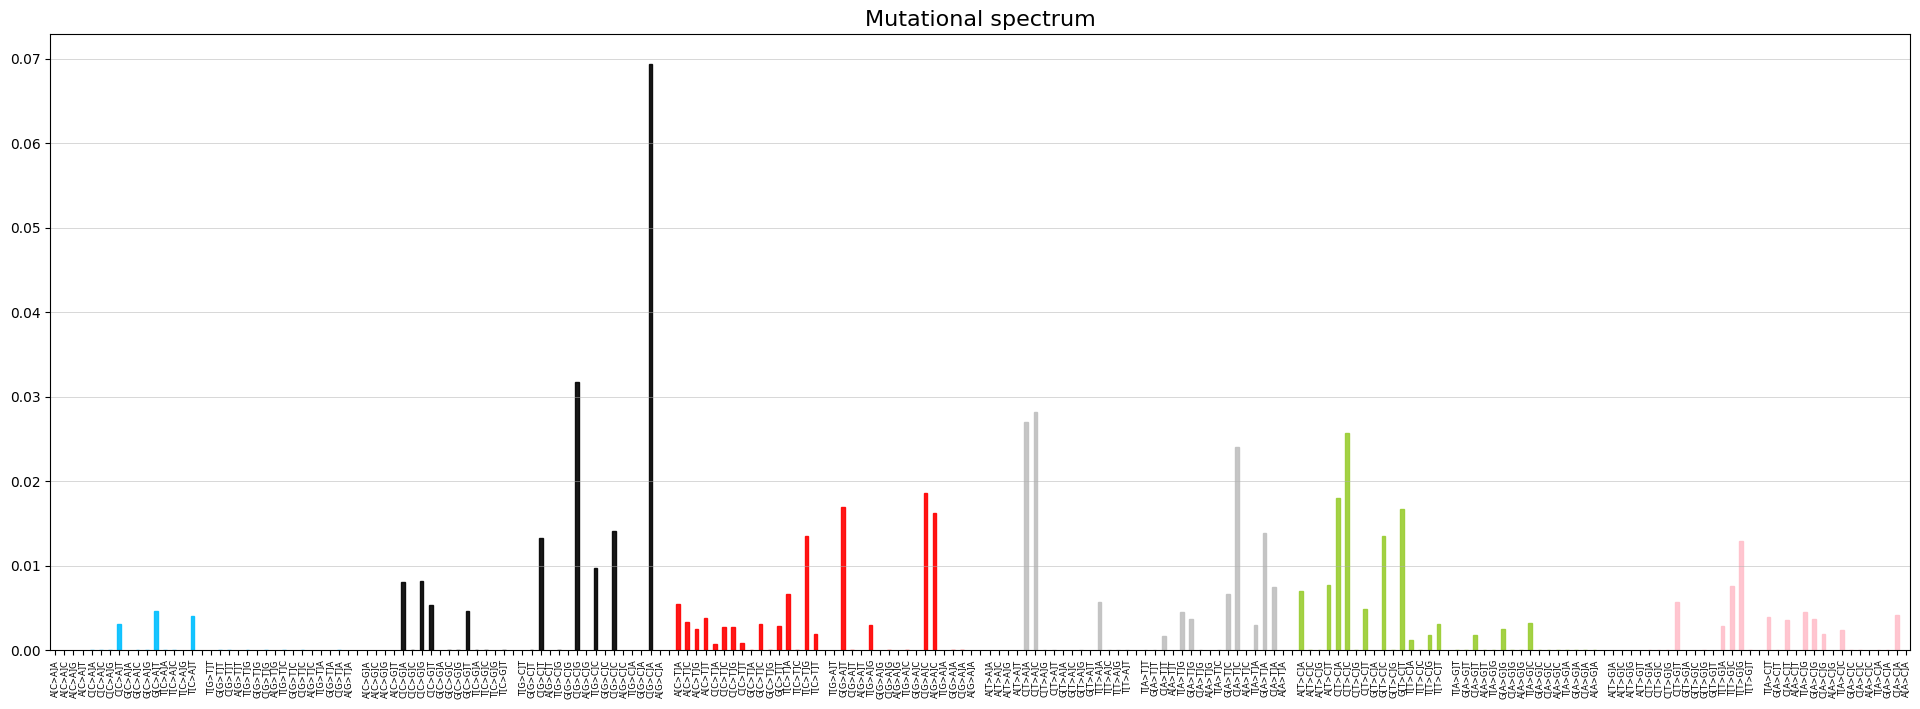

In [101]:
plot_mutspec192(ms192[ms192.ExpNum > 1]);

## Merge obs and exp to spectra tables

In [2]:
exp_freqs = pd.read_csv('../data/new_dataset/expected.csv')
obs = pd.read_csv('../data/new_dataset/obs_muts.csv')
obs['sbs12'] = obs.Mut.str.slice(2, 5)

In [80]:
_mut_col = 'sbs12'
exp_long = exp_freqs.set_index(['gene', 'class', 'species'])[possible_sbs12]\
    .melt(ignore_index=False, var_name=_mut_col, value_name='Expected').reset_index()
obs_long = obs.groupby(['gene', 'class', 'species', _mut_col])['ProbaMut'].sum()\
    .rename('Observed').reset_index()

spectra12 = obs_long.merge(exp_long, 'right', ['gene', 'class', 'species', _mut_col])
# spectra12 = obs_long.merge(exp_long, on=['gene', 'class', 'species', _mut_col])
spectra12.rename(
    columns={'gene': 'Gene', 'class': 'Class', 
             'species': 'Species', _mut_col: 'Mut'},
    inplace=True)
spectra12['RawMutSpec'] = spectra12['Observed'] / spectra12['Expected']

RawMutSpec = spectra12.groupby(['Gene', 'Class', 'Species'])\
    .RawMutSpec.sum().rename('RawMutSpecSum')

spectra12 = spectra12.merge(RawMutSpec, on=['Gene', 'Class', 'Species'])
spectra12['MutSpec'] = (spectra12['RawMutSpec'] / spectra12['RawMutSpecSum']).fillna(0.)
spectra12.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1, inplace=True)
spectra12

,Gene,Class,Species,Mut,Observed,Expected,MutSpec
0,CO1,Mammalia,Crocuta_crocuta,A>C,NaN,115.066667,0.000000
1,CO1,Mammalia,Crocuta_crocuta,A>G,11.500444,173.333333,0.162818
2,CO1,Mammalia,Crocuta_crocuta,A>T,NaN,115.066667,0.000000
3,CO1,Mammalia,Crocuta_crocuta,C>A,NaN,71.466667,0.000000
4,CO1,Mammalia,Crocuta_crocuta,C>G,NaN,71.466667,0.000000
...,...,...,...,...,...,...,...
54883,CO3,Amphibia,Hyla_meridionalis,G>C,NaN,6.285714,0.000000
54884,CO3,Amphibia,Hyla_meridionalis,G>T,NaN,6.285714,0.000000
54885,CO3,Amphibia,Hyla_meridionalis,T>A,NaN,31.714286,0.000000
54886,CO3,Amphibia,Hyla_meridionalis,T>C,NaN,76.785714,0.000000


In [83]:
spectra12.MutSpec.eq(0.).value_counts(normalize=True)

True     0.639448
False    0.360552
Name: MutSpec, dtype: float64

In [76]:
_mut_col = 'Mut'
exp_long = exp_freqs.set_index(['gene', 'class', 'species'])[possible_sbs192]\
    .melt(ignore_index=False, var_name=_mut_col, value_name='Expected').reset_index()
obs_long = obs.groupby(['gene', 'class', 'species', _mut_col])['ProbaMut'].sum()\
    .rename('Observed').reset_index()

# spectra192 = obs_long.merge(exp_long, on=['gene', 'class', 'species', _mut_col])
spectra192 = obs_long.merge(exp_long, 'right', ['gene', 'class', 'species', _mut_col])
spectra192.rename(
    columns={'gene': 'Gene', 'class': 'Class', 'species': 'Species'},
    inplace=True)
spectra192['RawMutSpec'] = spectra192['Observed'] / spectra192['Expected']

RawMutSpec = spectra192.groupby(['Gene', 'Class', 'Species'])\
    .RawMutSpec.sum().rename('RawMutSpecSum')

spectra192 = spectra192.merge(RawMutSpec, on=['Gene', 'Class', 'Species'])
spectra192['MutSpec'] = (spectra192['RawMutSpec'] / spectra192['RawMutSpecSum']).fillna(0.)
spectra192.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1, inplace=True)
spectra192

,Gene,Class,Species,Mut,Observed,Expected,MutSpec
0,CO1,Mammalia,Crocuta_crocuta,A[A>C]A,NaN,0.000000,0.0
1,CO1,Mammalia,Crocuta_crocuta,A[A>C]C,NaN,0.000000,0.0
2,CO1,Mammalia,Crocuta_crocuta,A[A>C]G,NaN,0.000000,0.0
3,CO1,Mammalia,Crocuta_crocuta,A[A>C]T,NaN,0.000000,0.0
4,CO1,Mammalia,Crocuta_crocuta,C[A>C]A,NaN,13.666667,0.0
...,...,...,...,...,...,...,...
878203,CO3,Amphibia,Hyla_meridionalis,G[T>G]T,NaN,0.000000,0.0
878204,CO3,Amphibia,Hyla_meridionalis,T[T>G]A,NaN,4.285714,0.0
878205,CO3,Amphibia,Hyla_meridionalis,T[T>G]C,NaN,2.285714,0.0
878206,CO3,Amphibia,Hyla_meridionalis,T[T>G]G,NaN,1.000000,0.0


In [84]:
spectra192.MutSpec.eq(0.).value_counts(normalize=True)

True     0.889727
False    0.110273
Name: MutSpec, dtype: float64

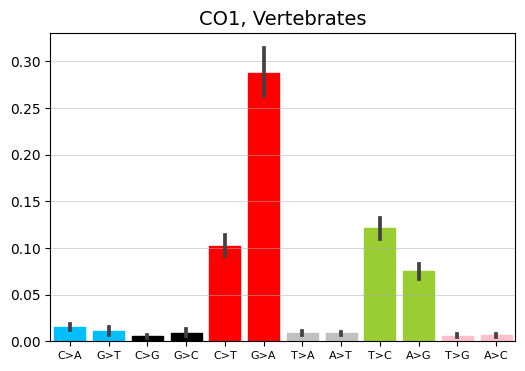

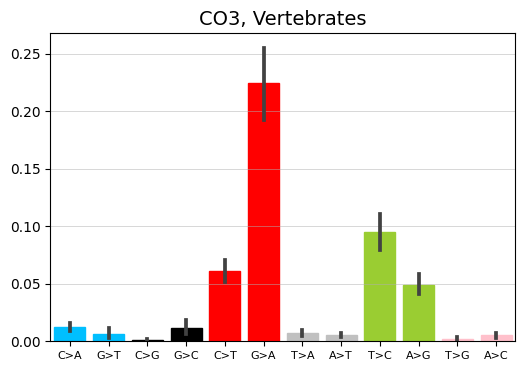

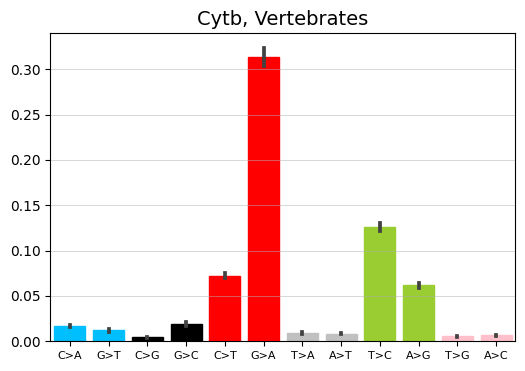

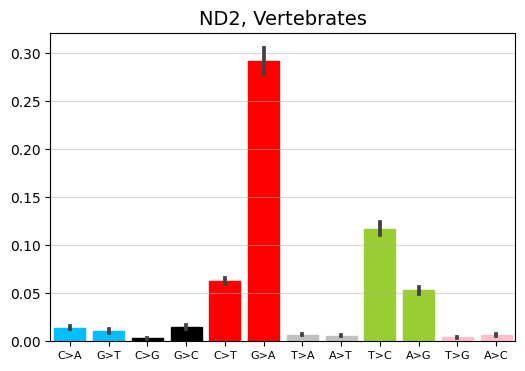

In [85]:
for g, gr in spectra12.groupby('Gene'):
    plot_mutspec12(gr, title=f'{g}, Vertebrates')

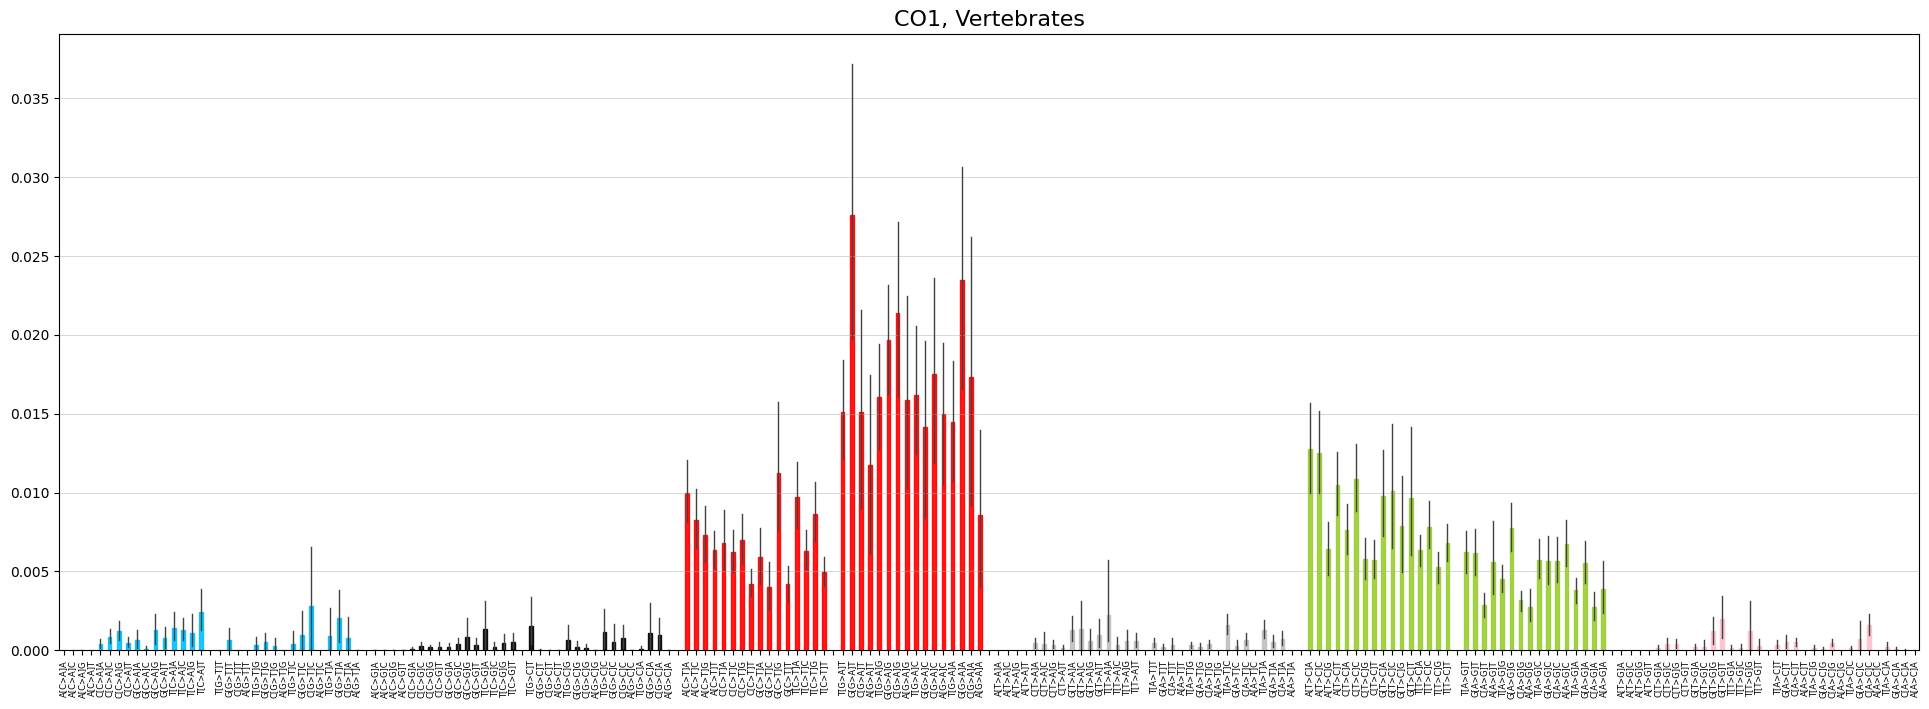

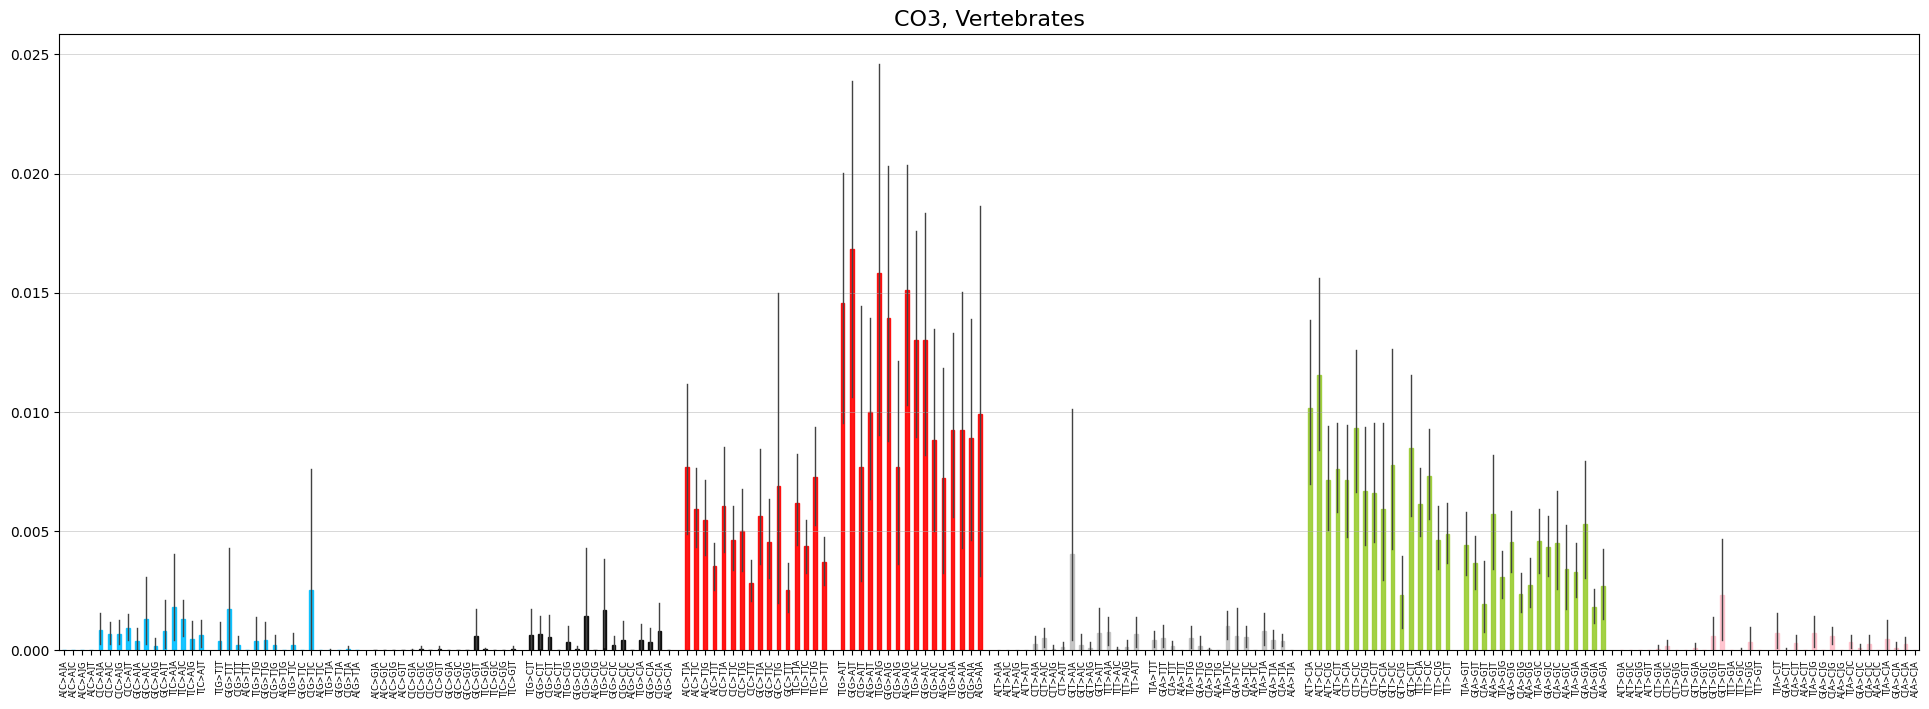

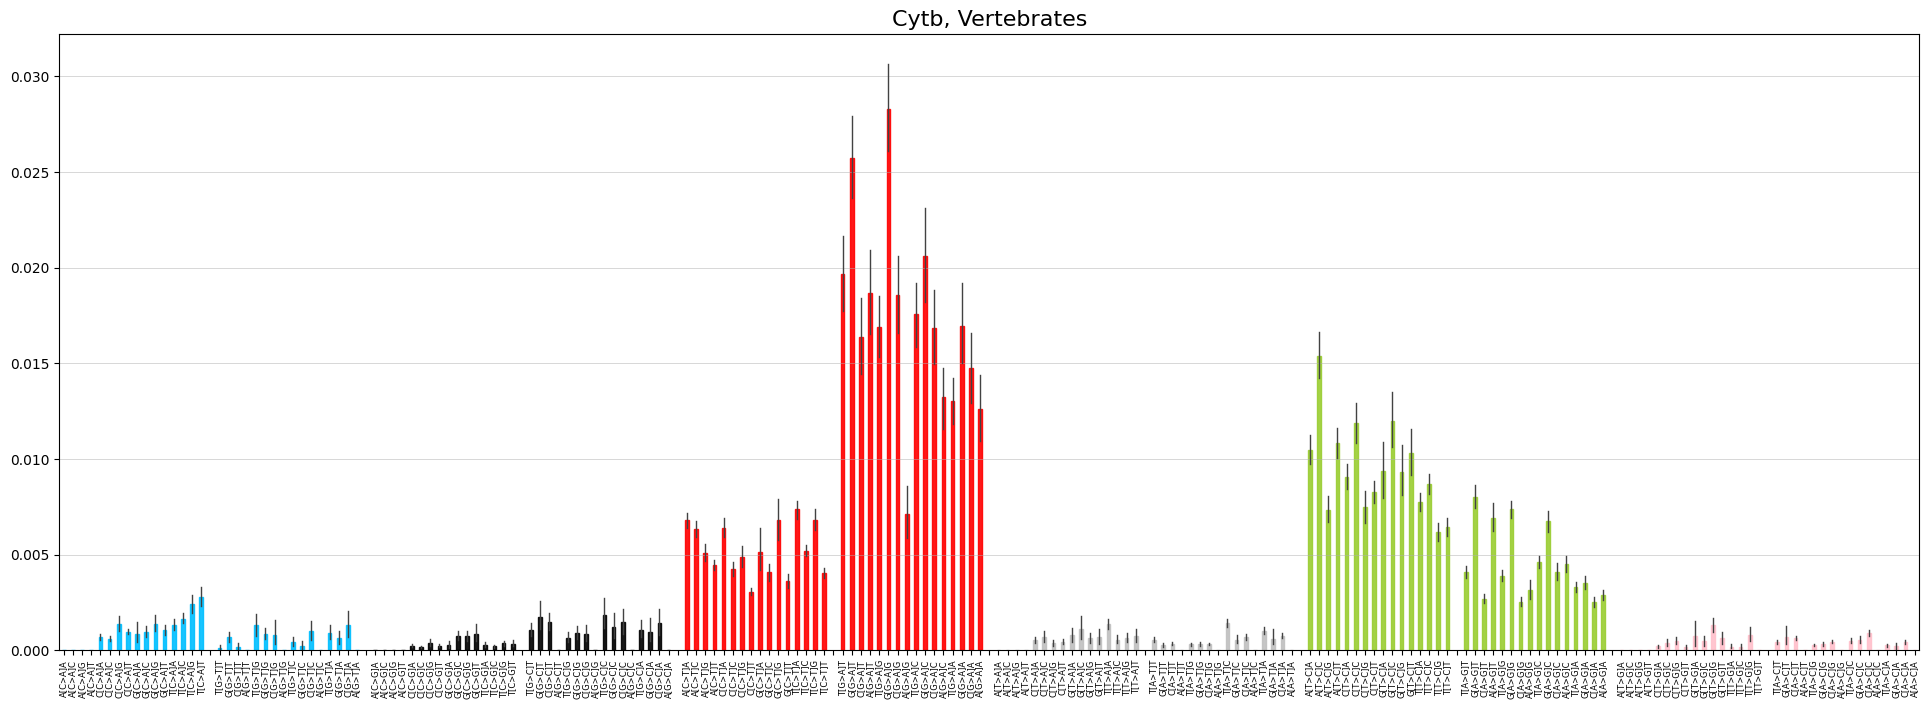

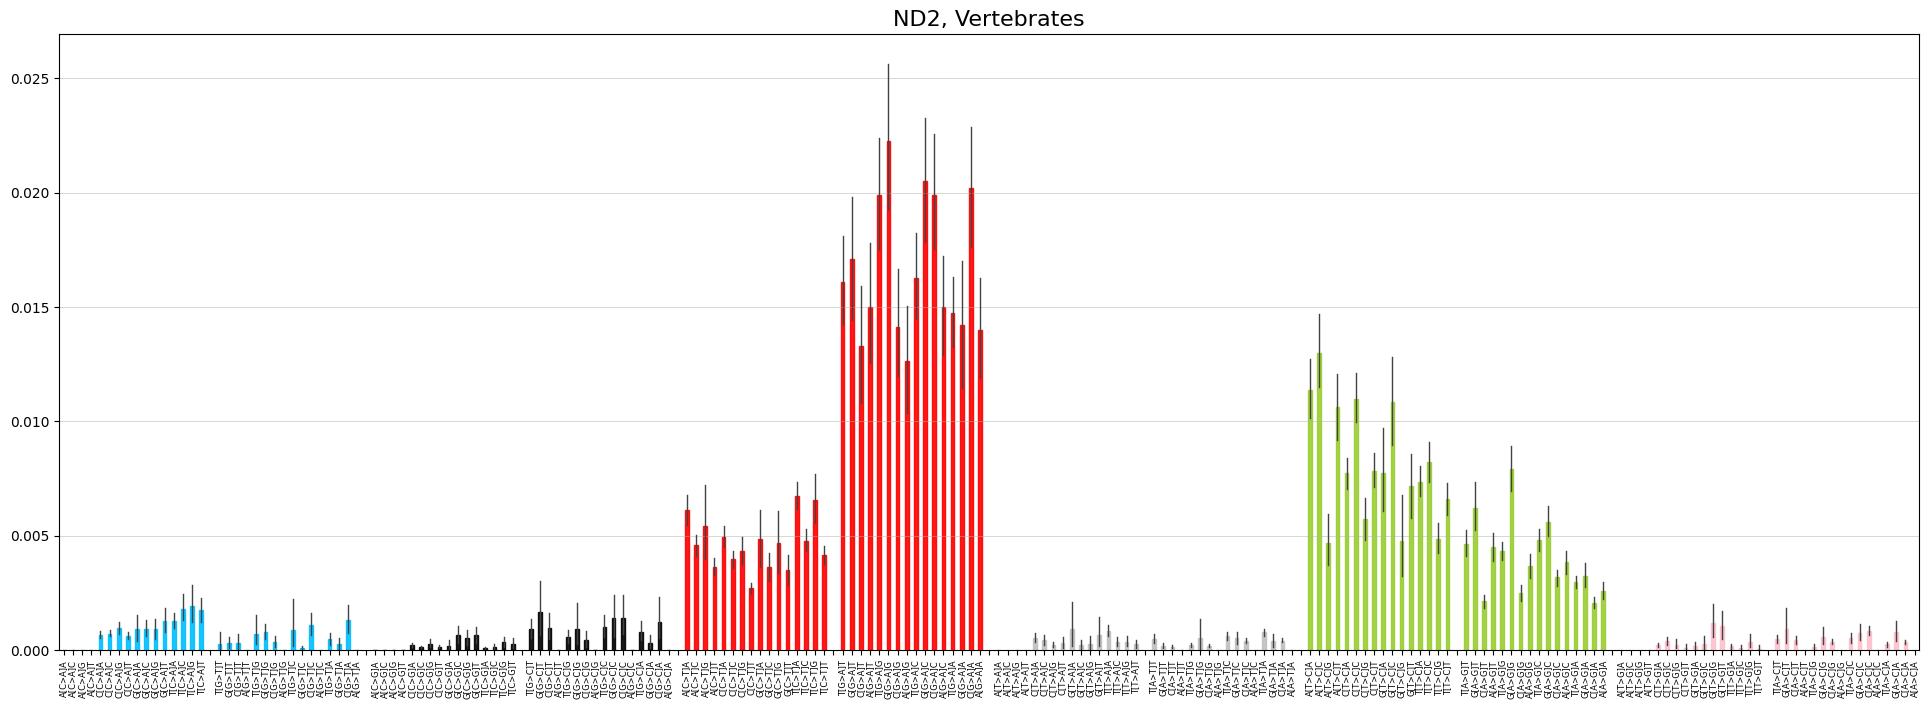

In [86]:
for g, gr in spectra192.groupby('Gene'):
    plot_mutspec192(gr, title=f'{g}, Vertebrates')

In [5]:
print('Species count with 192-comp spectrum')
spectra192.groupby(['Gene', 'Class']).Species.nunique().unstack()

Species count with 192-comp spectrum


Class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
Gene,,,,,
CO1,77,17,48,10,162
CO3,34,12,44,7,138
Cytb,901,95,256,257,1082
ND2,211,127,657,254,185


In [93]:
spectra12.to_csv('../data/new_dataset/MutSpecVertebrates12.csv.gz', 
                 index=False, compression='gzip')
spectra192.to_csv('../data/new_dataset/MutSpecVertebrates192.csv.gz', 
                  index=False, compression='gzip')

In [4]:
spectra192 = pd.read_csv('../data/new_dataset/MutSpecVertebrates192.csv.gz')

In [ ]:
old_dataset = pd.read_csv('../../192/data/MutSpecVertebratescytb.csv')
old_dataset['Mut'] = old_dataset['Mut'].apply(rev_comp)
old_dataset.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


## QC of exp

In [29]:
# number and share of useless values: (0, 0.9] - 10%
nuseless = ((exp_raw_df > 0) & (exp_raw_df <= 0.9)).sum().sum()
nuseless, (nuseless / exp_raw_df.size).round(4)

(188620, 0.0999)

In [30]:
(exp_raw_df > 0.9).sum().value_counts().sort_index()

0       32
1818     2
1879     2
2526     1
2560     3
        ..
9211     1
9227     2
9239     1
9249     2
9252     5
Length: 102, dtype: int64

In [31]:
(exp_raw_df > 0.9).sum().sum()

1207264

In [33]:
exp_raw_df = exp_raw_df[(exp_raw_df > 0.9)]

In [ ]:
# 12-comp exps are good
(exp_raw_df[possible_sbs12] > 0).sum(axis=1).sort_values()

A8__Henicorhina_leucophrys          8
ND3__Erythropitta_erythrogaster     9
ND3__Sus_scrofa                     9
A8__Calothorax_lucifer              9
CO3__Peromyscus_fraterculus         9
                                   ..
CO1__Coryphopterus_thrix           12
CO1__Vipera_ursinii                12
CO1__Austrolebias_nachtigalli      12
CO1__Cottus_gulosus                12
ND4L__Branchiostoma_belcheri       12
Length: 9252, dtype: int64

In [ ]:
# 192-comp exps are normal
(exp_raw_df[possible_sbs192] > 0).sum(axis=1).sort_values()

A8__Crotalus_triseriatus          12
A8__Artamus_superciliosus         21
A8__Hydrophis_elegans             24
A8__Potamotrygon_motoro           25
A8__Tor_khudree                   26
                                ... 
ND4__Rhinichthys_cataractae      157
ND5__Felis_silvestris            158
ND5__Felis_catus                 158
ND5__Phyllopteryx_taeniolatus    159
ND5__Boreogadus_saida            160
Length: 9252, dtype: int64

In [ ]:
exp_raw_df.to_csv('../data/chordata2/exp_num.csv')

## Process

In [4]:
total_data = [
    pd.read_csv('../data/new_dataset/raw_spectum12.csv', index_col=0),
    pd.read_csv('../data/new_dataset/raw_spectum192.csv', index_col=0),
]

In [5]:
df_info = pd.read_csv('../data/chordata2/info.csv')
df_info['species'] = df_info['species'].str.replace(' ', '_')
df_info

,acc,gene,taxa,species
0,AB478558.1.8820.9502_BAH86124.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_belcheri
1,AB478590.1.8806.9488_BAH86540.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_floridae
2,Y09525.1.238.>921_CAA70712.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_lanceolatum
3,KP722183.1.159.>838_AJV90905.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_fluviatilis
4,FR669668.2.1432.>2101_CBW30998.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_planeri
...,...,...,...,...
18932,KY676708.1.1.519_AVM18678.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea_braggi
18933,KY676695.1.1.519_AVM18665.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea_spelaea
18934,EU880310.1.14048.13530_ACJ43568.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops_ensicauda
18935,EU880313.1.14046.13528_ACJ43607.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops_pyrrhogaster


### Calculate class abundance

In [13]:
cab = total_data[0].merge(df_info, right_on=['species', 'gene'], left_on=['Species', 'Gene'])
cab['cls'] = cab.taxa.apply(lambda x: ' '.join(x.split(';')[1].split('_')[:-1]))
abund = cab.drop_duplicates(['species', 'gene']).groupby(['cls', 'gene']).Species.count()\
    .unstack().fillna(0).astype(int).sort_values('Cytb', ascending=False)

abund = abund.append(abund.sum().rename('All classes'))

abund.to_csv('../ToPaper/SuplFiles/Supplementary_Table_3.csv')
abund

gene,A6,A8,CO1,CO2,CO3,Cytb,ND1,ND2,ND3,ND4,ND4L,ND5,ND6
cls,,,,,,,,,,,,,
Mammalia,121,70,309,145,142,1123,153,210,97,174,81,155,118
Actinopteri,167,56,334,31,34,1026,76,235,25,68,21,57,40
Lepidosauria,51,21,110,7,8,435,61,425,5,337,5,12,8
Aves,122,23,79,40,44,314,44,718,79,60,14,57,61
Amphibia,14,5,135,8,13,242,63,181,22,52,5,20,12
class Testudines,0,0,3,0,0,40,1,1,1,16,0,2,2
class Crocodylia,1,1,3,1,1,10,1,1,1,1,1,1,1
Hyperoartia,2,1,1,0,0,9,0,1,1,0,0,0,0
Chondrichthyes,5,3,15,1,1,8,1,46,0,5,0,4,1


In [6]:
# used data
abund.loc[abund.index.values[:5], ['Cytb', 'CO1', 'ND2']]

NameError: name 'abund' is not defined

## Get final tables; find min number of mutations threshold 

In [7]:
total_data[0]

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
0,A>G,11.97280,30.91470,0.370075,Eleotris_fusca,ND1
1,C>T,4.98631,46.08120,0.103398,Eleotris_fusca,ND1
2,G>A,6.98846,21.08200,0.316758,Eleotris_fusca,ND1
3,T>C,8.98184,40.91500,0.209769,Eleotris_fusca,ND1
4,T>A,0.00000,16.91510,0.000000,Eleotris_fusca,ND1
...,...,...,...,...,...,...
7,T>C,2.99998,40.79990,0.026493,Branchiostoma_belcheri,ND4L
8,T>G,3.99994,10.90000,0.132223,Branchiostoma_belcheri,ND4L
9,G>T,0.00000,4.69996,0.000000,Branchiostoma_belcheri,ND4L
10,A>C,0.00000,12.90000,0.000000,Branchiostoma_belcheri,ND4L


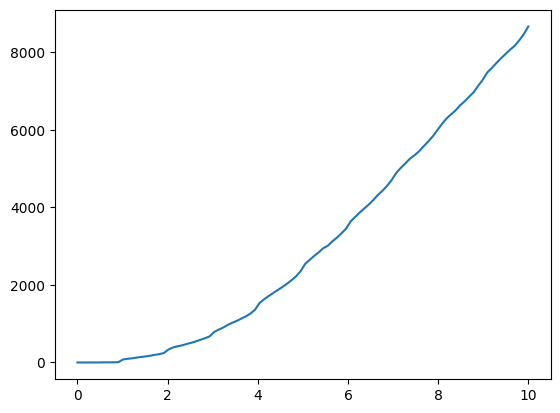

In [8]:
tr_space = np.linspace(0, 10, 100)
dlen = [total_data[0][(total_data[0].ExpNum.between(0, tr, 'right')) \
                    & (total_data[0].ObsNum.between(0, tr, 'right'))].shape[0] for tr in tr_space]

plt.plot(tr_space, dlen)

In [9]:
tr = 0.99
total_data[0][(total_data[0].ExpNum.between(0, tr, 'right')) & (total_data[0].ObsNum.between(0, tr, 'right'))] #& (~(total_data[0].ObsNum / total_data[0].ExpNum).fillna(0).between(0.8, 1.2))]

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
4,G>C,0.984329,0.532810,0.293537,Podarcis_lilfordi,ND2
6,G>T,0.981711,0.943558,0.099573,Pedioplanis_burchelli,ND2
6,G>T,0.808355,0.537496,0.197909,Didemnum_granulatum,CO1
4,G>A,0.899284,0.872553,0.368168,Crotaphytus_nebrius,Cytb
7,G>C,0.567060,0.320491,0.394275,Reithrodontomys_chrysopsis,Cytb
5,G>A,0.973297,0.571058,0.592833,Dipodomys_agilis,Cytb
6,G>T,0.800593,0.911391,0.123866,Misgurnus_anguillicaudatus,A8
4,G>T,0.984943,0.317911,0.396533,Phrynosoma_orbiculare,A8
2,G>A,0.966622,0.305126,0.656641,Dicrostonyx_torquatus,A8
1,C>A,0.317641,0.022745,0.694539,Pituophis_deppei,A8


In [10]:
total_data[0][(total_data[0].ExpNum.between(0.99, 1, 'right')) | (total_data[0].ObsNum.between(0.99, 1, 'right'))] 

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
3,C>G,1.00000,23.59860,0.012763,Anaxyrus_fowleri,ND1
1,A>T,1.00000,80.26720,0.011597,Anaxyrus_woodhousii,ND1
5,G>C,1.00000,6.67245,0.139505,Anaxyrus_woodhousii,ND1
2,A>T,1.00000,22.64750,0.021682,Corvus_corax,ND1
8,T>G,0.99997,21.06580,0.010808,Lasiopodomys_gregalis,ND1
...,...,...,...,...,...,...
1,C>A,1.00000,13.99980,0.103928,Macrhybopsis_aestivalis,ND4L
5,T>G,1.00000,8.98997,0.161843,Macrhybopsis_aestivalis,ND4L
2,C>A,0.99998,2.50000,0.144122,Branchiostoma_belcheri,ND4L
5,G>C,0.99995,4.69996,0.076659,Branchiostoma_belcheri,ND4L


In [11]:
tr = 0.99
get_cossim(
    total_data[0].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'), 
    total_data[0][(total_data[0].ExpNum >= tr) & (total_data[0].ObsNum >= tr)].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'),
).quantile([.05, .5])

0.05    0.988551
0.50    1.000000
dtype: float64

### Use cytb exp full

In [12]:
exp_raw_df = pd.read_csv('../data/chordata2/exp_num.csv', index_col=0)
exp_raw_df = exp_raw_df[exp_raw_df.index.str.startswith('Cytb__')]
exp_raw_df.index = exp_raw_df.index.str.slice(6)
# exp_raw_df12 = exp_raw_df[possible_sbs12].fillna(0.)
exp_raw_df = exp_raw_df[possible_sbs192].fillna(0.)
exp_raw_df.head(2)

,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
gene__species,,,,,,,,,,,,,,,,,,,,,
Aulacorhynchus_haematopygus,0.0,0.0,0.0,0.0,8.300000,4.300000,8.500000,8.6,2.800000,1.90000,...,3.000000,0.000000,0.0,0.0,1.800000,1.000000,1.000000,1.500000,1.400000,1.8
Tarsius_dentatus,0.0,0.0,0.0,0.0,11.571429,10.380952,10.142857,13.0,3.857143,3.47619,...,8.333333,4.142857,1.0,0.0,1.190476,1.428571,3.047619,2.857143,2.142857,0.0


### Species-specific compare: obs, exp and spectum

In [13]:
exp_freqs_new_full = exp_raw_df[possible_sbs192]

obs_freqs_new = total_data[1].pivot(['Gene', 'Species'], 'Mut', 'ObsNum').loc['Cytb', possible_sbs192]
exp_freqs_new_excons = total_data[1].pivot(['Gene', 'Species'], 'Mut', 'ExpNum').loc['Cytb', possible_sbs192]

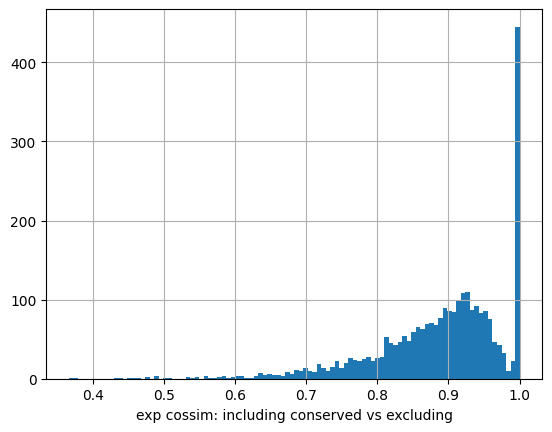

In [14]:
plt.xlabel('exp cossim: including conserved vs excluding')
get_cossim(exp_freqs_new_excons, exp_freqs_new_full).hist(bins=100);

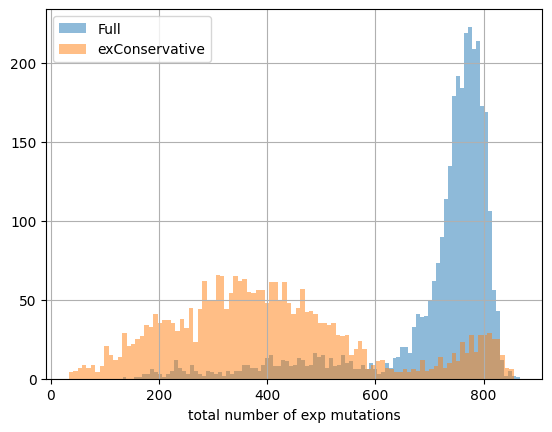

In [15]:
exp_freqs_new_full.sum(axis=1).hist(bins=100, alpha=0.5, label='Full')
exp_freqs_new_excons.sum(axis=1).hist(bins=100, alpha=0.5, label='exConservative')
plt.xlabel('total number of exp mutations')
plt.legend();

## Compare with old dataset 

In [113]:
old_dataset = pd.read_csv('../../192/data/MutSpecVertebratescytb.csv')
old_dataset['Mut'] = old_dataset['Mut'].apply(rev_comp)
old_dataset.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [17]:
obs_freqs_old = old_dataset.pivot('Species', 'Mut', 'Observed')[possible_sbs192]
exp_freqs_old = old_dataset.pivot('Species', 'Mut', 'Expected')[possible_sbs192]

In [18]:
thr_obs = 0.9
thr_exp = 0.9

# obs_freqs_old_filtered = obs_freqs_old[obs_freqs_old > thr].fillna(0.) # useless, there are no proba...
# exp_freqs_old_filtered = exp_freqs_old[exp_freqs_old > thr].fillna(0.)
obs_freqs_new_filtered = obs_freqs_new[obs_freqs_new > thr_obs].fillna(0.)
exp_freqs_new_full_filtered = exp_freqs_new_full[exp_freqs_new_full > thr_exp].fillna(0.)
exp_freqs_new_excons_filtered = exp_freqs_new_excons[exp_freqs_new_excons > thr_exp].fillna(0.)

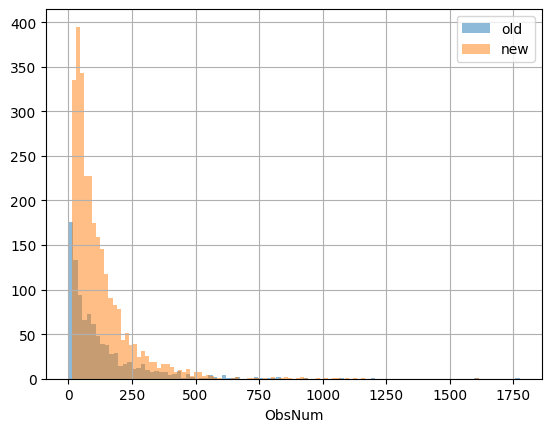

In [19]:
obs_freqs_old.sum(axis=1).hist(bins=100, label='old', alpha=0.5)
obs_freqs_new.sum(axis=1).hist(bins=100, label='new', alpha=0.5)
plt.xlabel('ObsNum')
plt.legend();

In [23]:
transitions = [x for x in possible_sbs192 if x[2:5] in set(['C>T', 'T>C', 'A>G', 'G>A'])]
len(transitions)

64

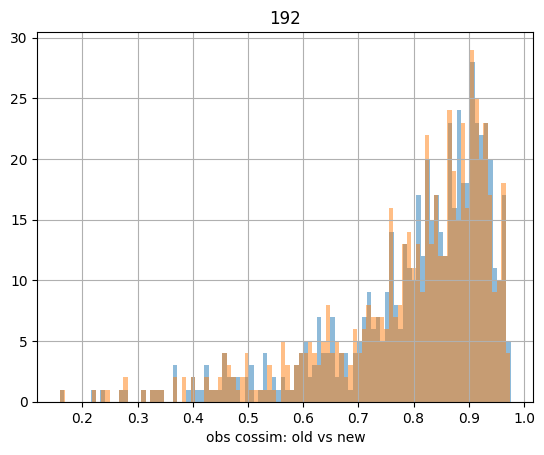

In [24]:
get_cossim(obs_freqs_new, obs_freqs_old).hist(bins=100, alpha=0.5)
get_cossim(obs_freqs_new_filtered, obs_freqs_old).hist(bins=100, alpha=0.5)
plt.xlabel('obs cossim: old vs new');
plt.title('192');

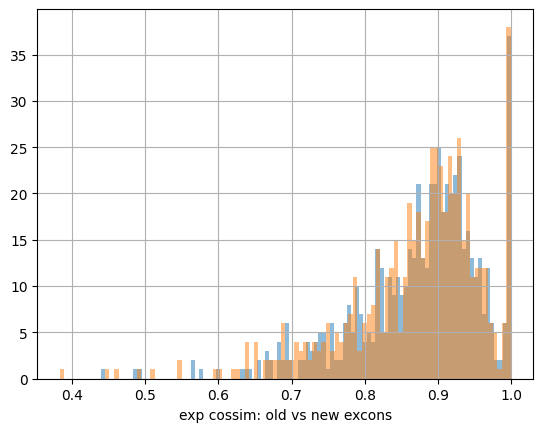

In [13]:
get_cossim(exp_freqs_new_excons, exp_freqs_old).hist(bins=100, alpha=0.5)
get_cossim(exp_freqs_new_excons_filtered, exp_freqs_old).hist(bins=100, alpha=0.5)
plt.xlabel('exp cossim: old vs new excons');

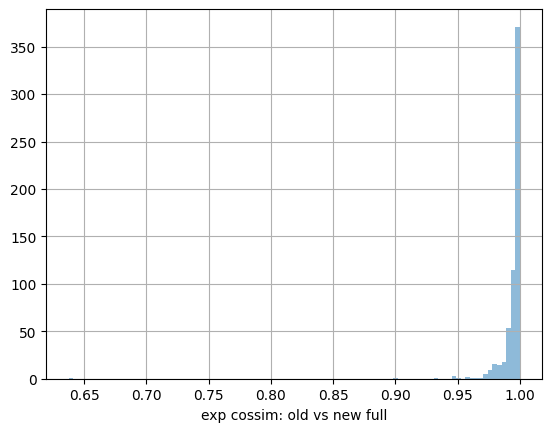

In [27]:
get_cossim(exp_freqs_new_full, exp_freqs_old).hist(bins=100, alpha=0.5)
plt.xlabel('exp cossim: old vs new full');

In [28]:
spectrum_old = (obs_freqs_old / exp_freqs_old).fillna(0.).replace(np.inf, 0.)

spectrum_new_full = (obs_freqs_new / exp_freqs_new_full).fillna(0.).replace(np.inf, 0.)
spectrum_new_excons = (obs_freqs_new / exp_freqs_new_excons).fillna(0.).replace(np.inf, 0.)

spectrum_new_full_filtered   = (obs_freqs_new_filtered / exp_freqs_new_full_filtered).fillna(0.).replace(np.inf, 0.)
spectrum_new_excons_filtered = (obs_freqs_new_filtered / exp_freqs_new_excons_filtered).fillna(0.).replace(np.inf, 0.)

### Cossims

<AxesSubplot:>

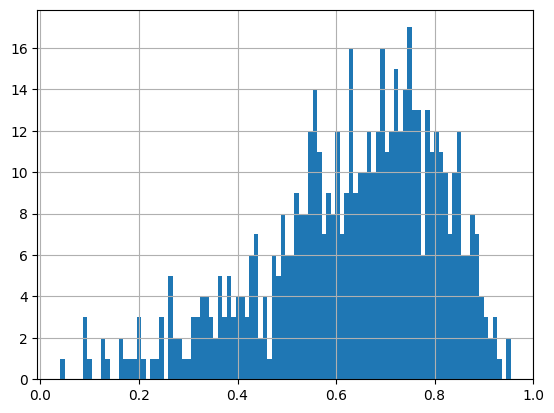

In [29]:
get_cossim(spectrum_old, spectrum_new_full).hist(bins=100)

0.6192324563775156 0.6316463413230912


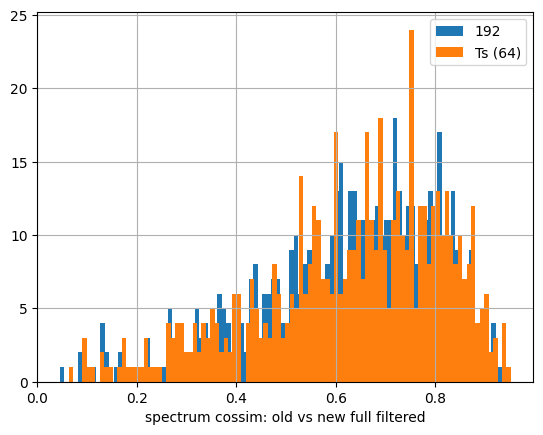

In [31]:
a = get_cossim(spectrum_old, spectrum_new_full_filtered)
b = get_cossim(spectrum_old[transitions], spectrum_new_full_filtered[transitions])
print(a.mean(), b.mean())
a.hist(bins=100, label='192')
b.hist(bins=100, label='Ts (64)')
plt.xlabel('spectrum cossim: old vs new full filtered')
plt.legend()
plt.show()

### Need to compare only values of sbs, that was observed in old dataset!
old dataset has more zeroes, therefore when calculating cossim, huge difference raised from zeroes,
that are not zeroes in the new dataset

In [96]:
from scipy.spatial.distance import cosine
cosine([1,2,3,4], [1,0,3,4])

0.06905066374873725

In [19]:
species = obs_freqs_old.index.intersection(obs_freqs_new.index)


obs_freqs_new_filtered_as_in_old = obs_freqs_new_filtered.loc[species][obs_freqs_old.loc[species] > 0].fillna(0.)

spectrum_new_full_filtered_as_in_old = (obs_freqs_new_filtered_as_in_old / exp_freqs_new_full_filtered)\
                                            .fillna(0.).replace(np.inf, 0.)

0.6640302629311805


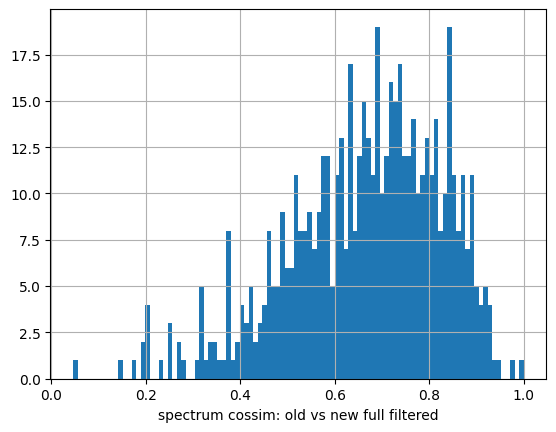

In [20]:
a = get_cossim(spectrum_old, spectrum_new_full_filtered_as_in_old)
print(a.mean())
a[a>0].hist(bins=100)
plt.xlabel('spectrum cossim: old vs new full filtered');

0.9012186784038454


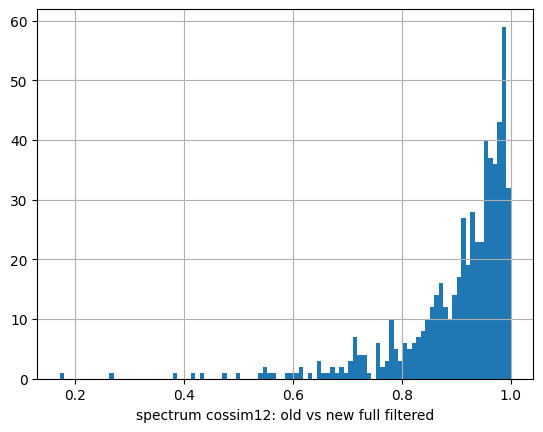

In [26]:
# 12-comp
a = get_cossim(
    collapse_sbs192(spectrum_old), 
    collapse_sbs192(spectrum_new_full_filtered_as_in_old))
print(a.mean())
a[a>0].hist(bins=100)
plt.xlabel('spectrum cossim12: old vs new full filtered');

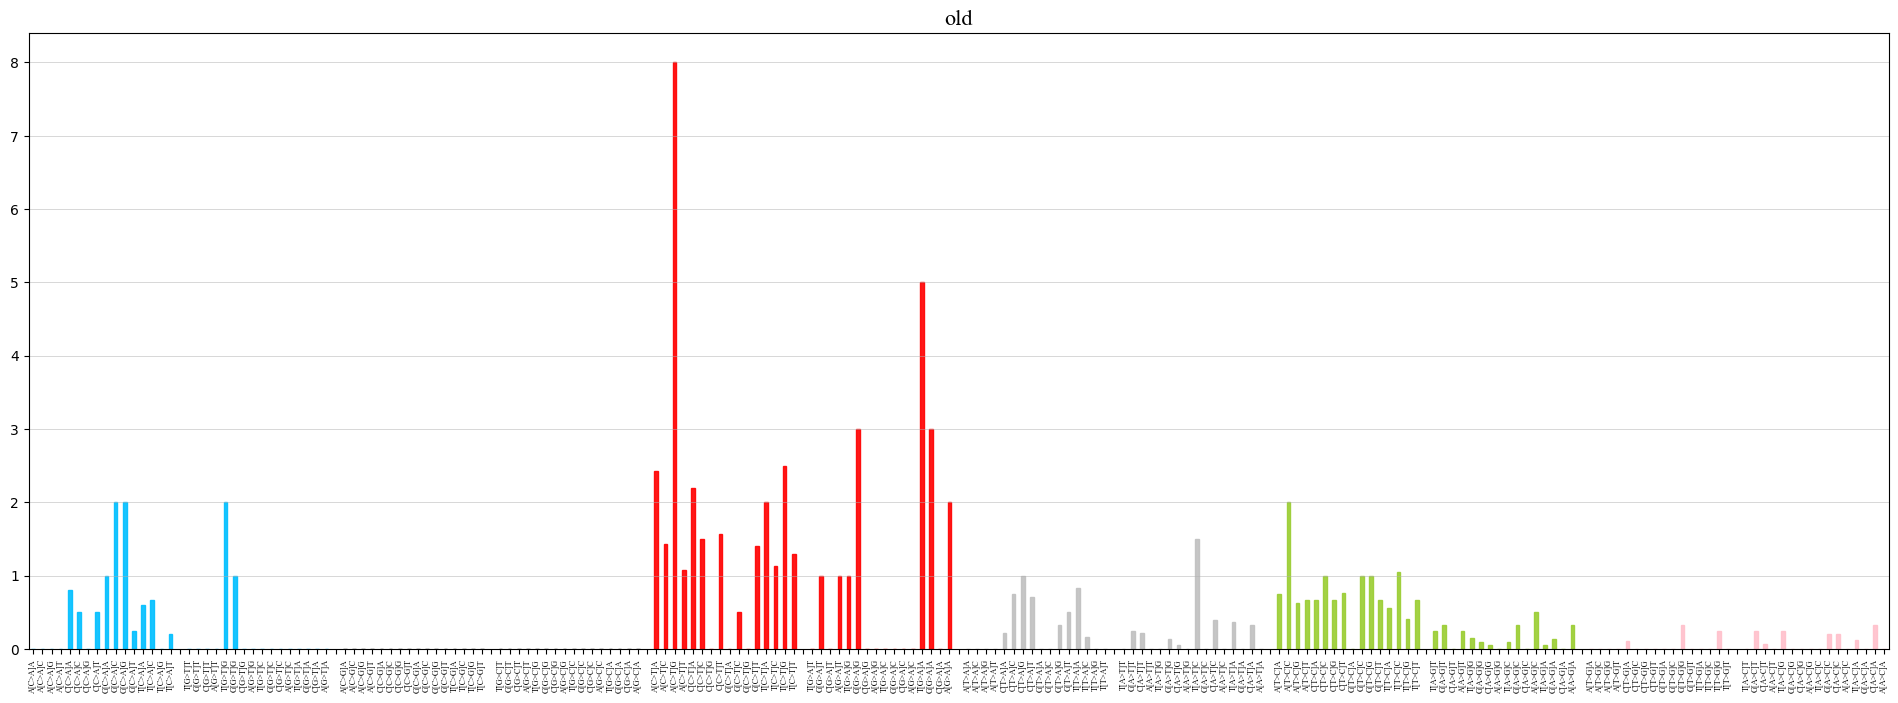

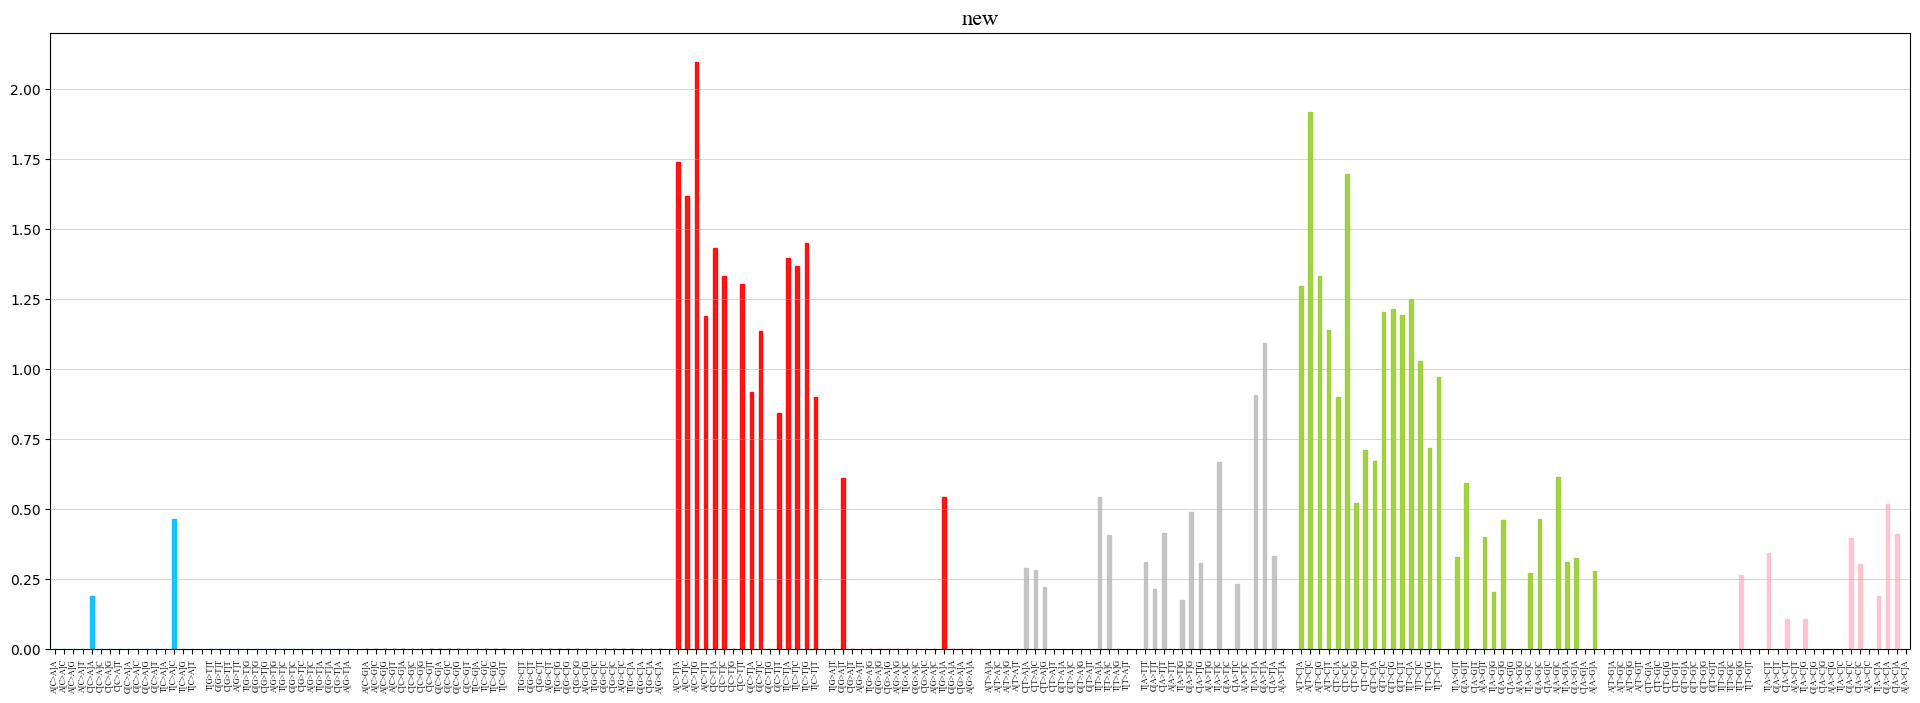

In [186]:
o = spectrum_old.sample()
if o.index.values.item() in spectrum_new_full_filtered.index:
    n = spectrum_new_full_filtered.loc[o.index.values.item()]
    plot_mutspec192(o.iloc[0].to_frame('MutSpec').reset_index(), title='old');
    plot_mutspec192(n.to_frame('MutSpec').reset_index(), title='new');
else:
    print('again')

### Plot barplot of mean spectrum

In [130]:
def scale_spectrum(df):
    return (df.T / df.sum(axis=1)).T

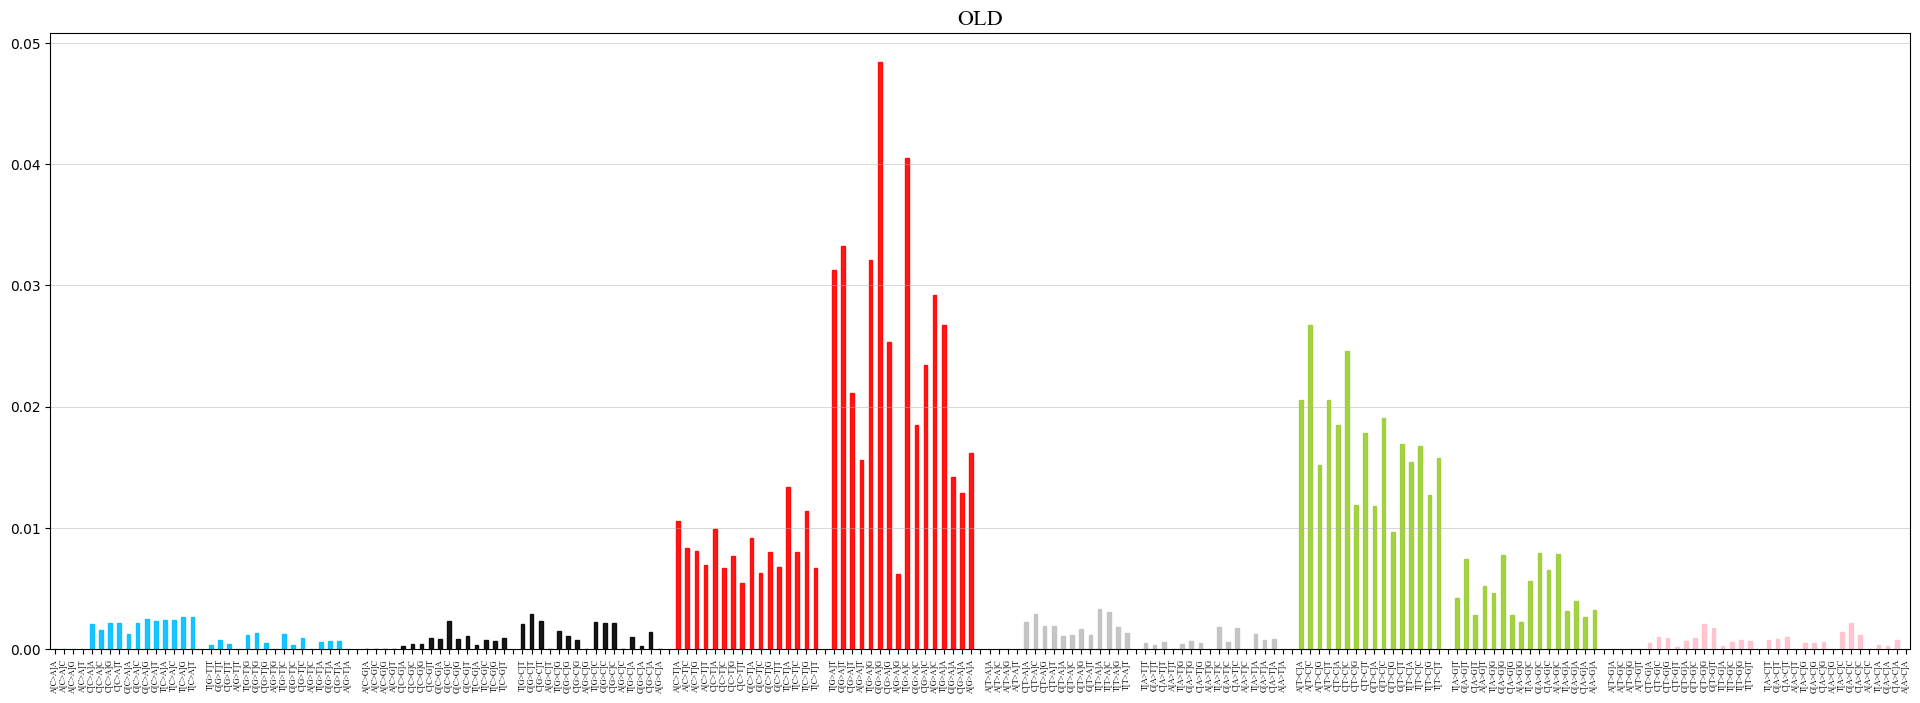

In [131]:
plot_mutspec192(scale_spectrum(spectrum_old).mean(axis=0).rename('MutSpec').to_frame().reset_index(), title='OLD');

In [132]:
species = spectrum_old.index.intersection(spectrum_new_full.index).intersection(spectrum_new_excons.index)

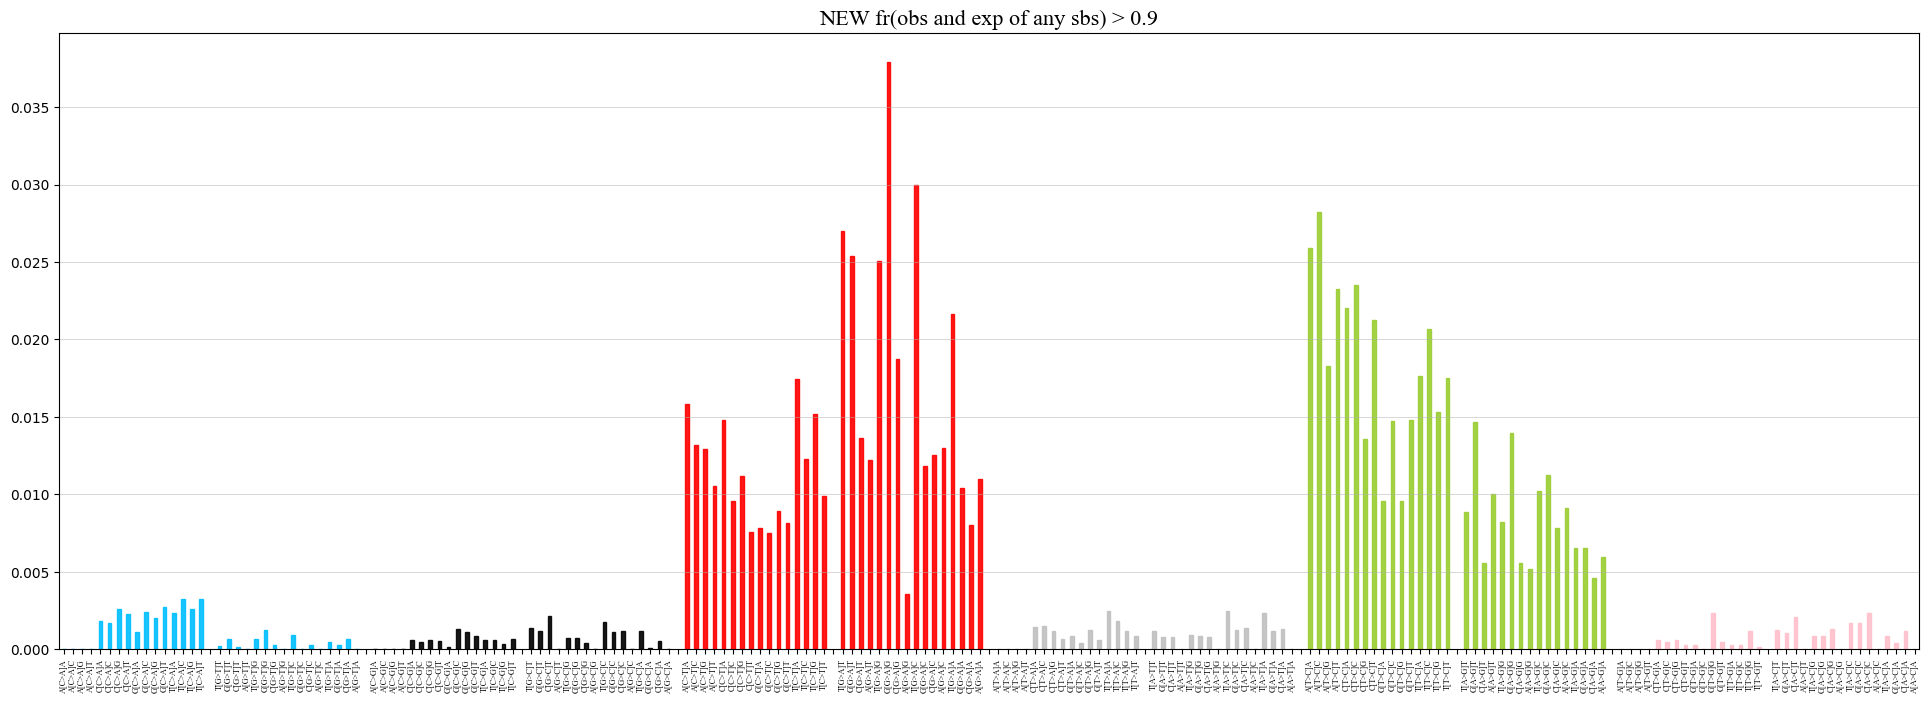

In [133]:
plot_mutspec192(scale_spectrum(spectrum_new_full_filtered.loc[species])\
                    .mean(axis=0).rename('MutSpec').to_frame().reset_index(), title='NEW fr(obs and exp of any sbs) > 0.9');

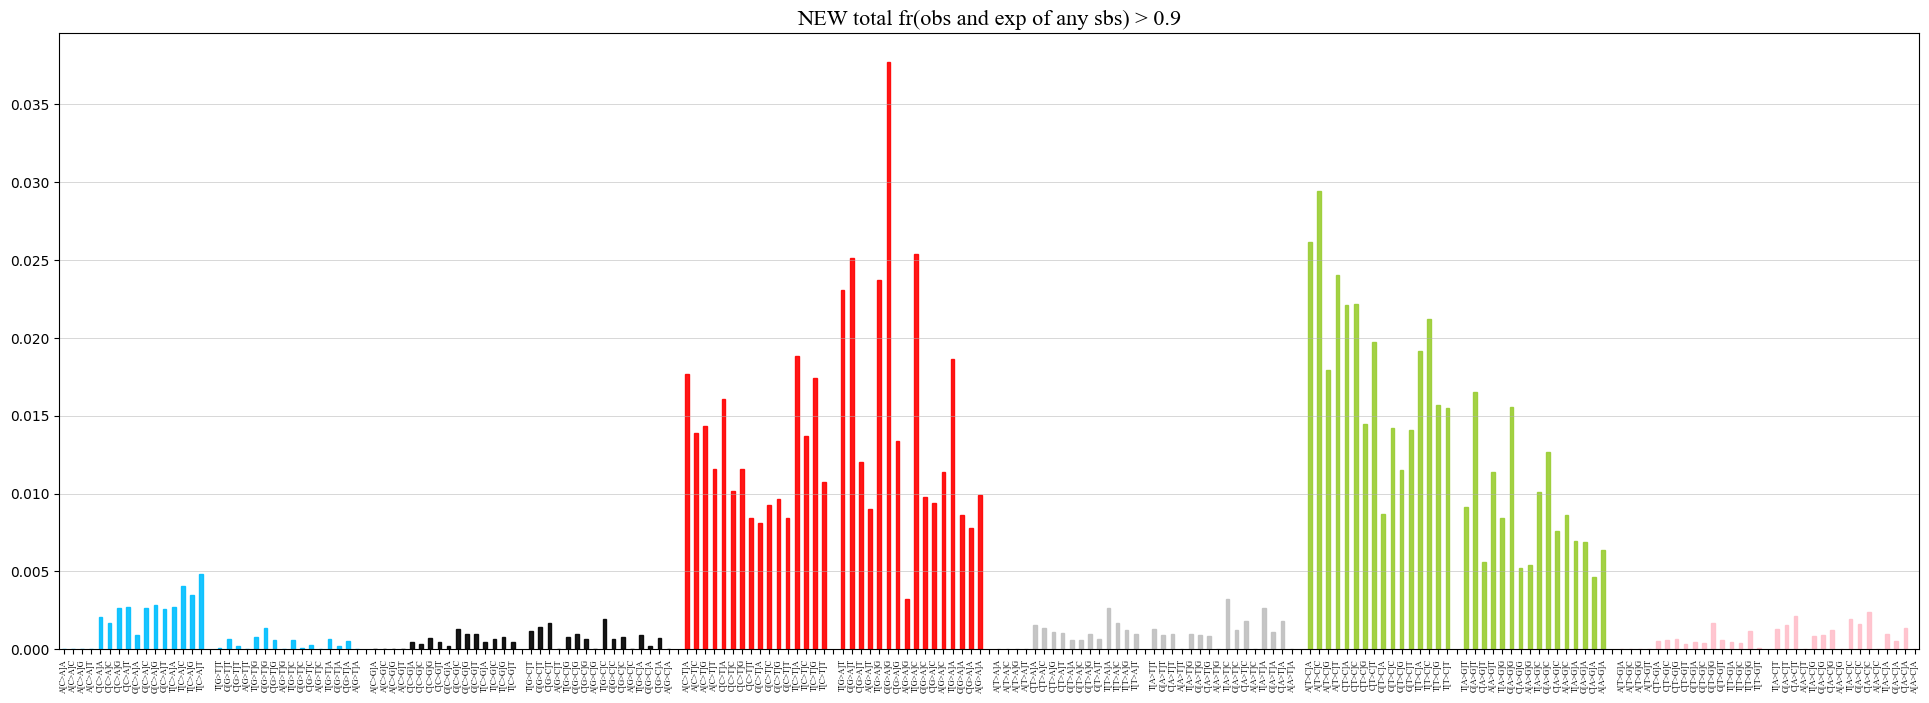

In [134]:
plot_mutspec192(scale_spectrum(spectrum_new_full_filtered)\
                    .mean(axis=0).rename('MutSpec').to_frame().reset_index(), title='NEW total fr(obs and exp of any sbs) > 0.9');

In [ ]:
plot_mutspec192(scale_spectrum(spectrum_new_full.loc[species])\
                    .mean(axis=0).rename('MutSpec').to_frame().reset_index(), title='NEW');

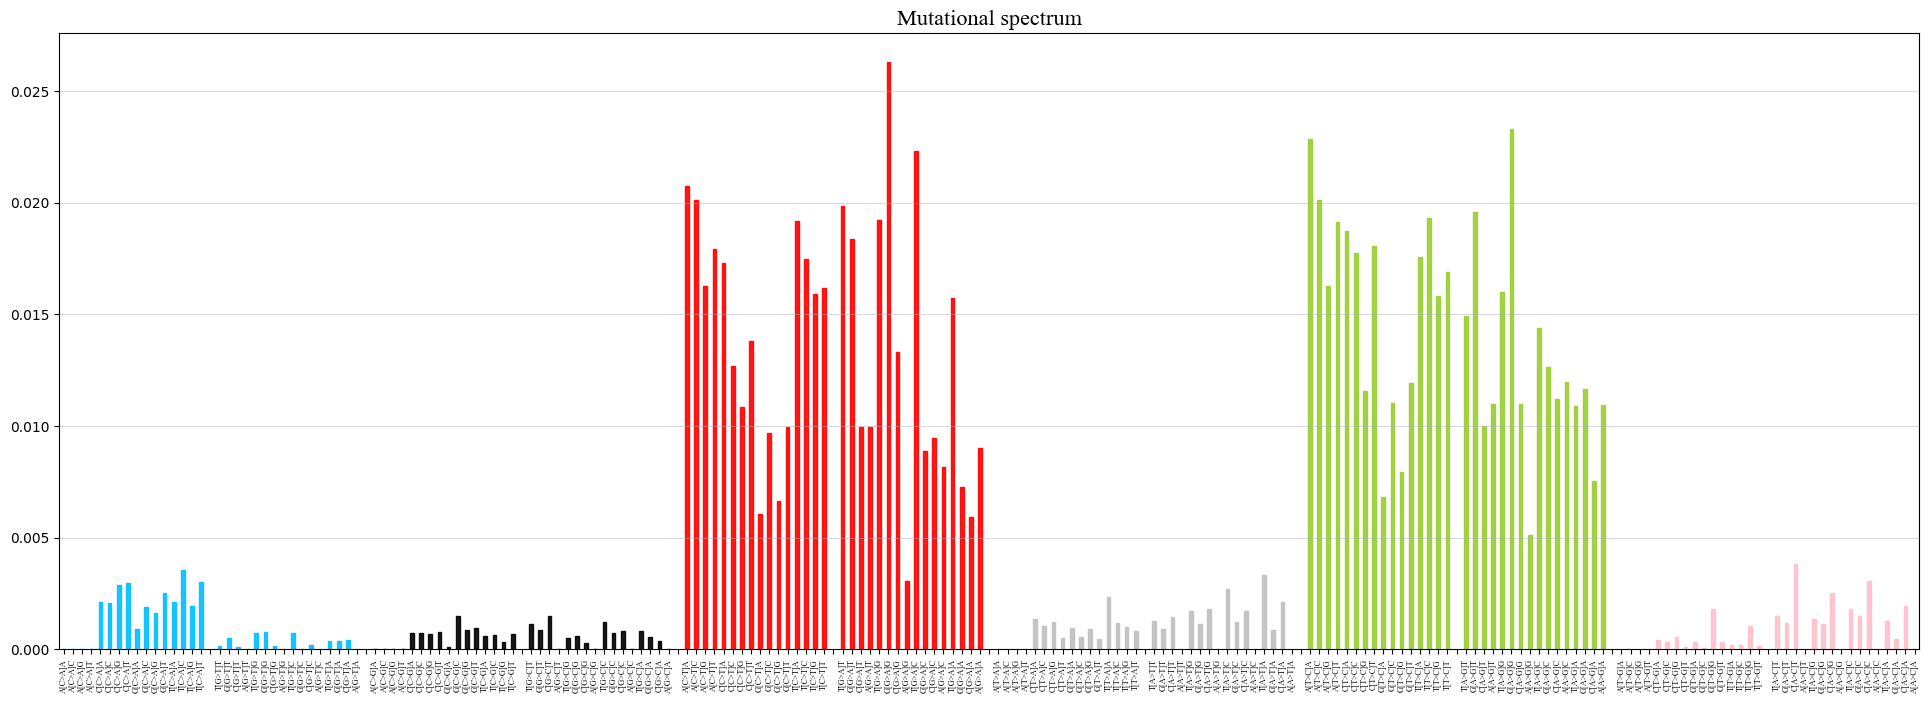

In [94]:
plot_mutspec192(scale_spectrum(spectrum_new_excons_filtered.loc[species])\
                    .mean(axis=0).rename('MutSpec').to_frame().reset_index());

## Save final tables

### save

In [18]:
exp = pd.read_csv('../data/chordata2/exp_num.csv', index_col=0)

In [31]:
exp.head(2)

,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
ND1__Eleotris_fusca,NaN,NaN,NaN,NaN,14.076923,8.461538,13.000000,6.769231,2.000000,NaN,...,82.230769,58.230769,58.230769,137.923077,24.307692,15.384615,15.384615,23.076923,61.461538,23.076923
ND1__Lasiurus_blossevillii,NaN,NaN,NaN,NaN,7.909091,9.636364,6.090909,10.272727,1.909091,NaN,...,72.090909,35.909091,35.909091,93.909091,22.727273,9.000000,9.000000,29.000000,93.181818,29.000000


In [38]:
total_data[0]['gene__species'] = total_data[0].Gene + '__' + total_data[0].Species
total_data[1]['gene__species'] = total_data[1].Gene + '__' + total_data[1].Species

In [ ]:
obs_freqs_new = total_data[1].pivot(['Gene', 'Species'], 'Mut', 'ObsNum').loc['Cytb', possible_sbs192]

In [39]:
obs12  = total_data[0].pivot('gene__species', 'Mut', 'ObsNum')[possible_sbs12]
obs192 = total_data[1].pivot('gene__species', 'Mut', 'ObsNum')[possible_sbs192]

In [46]:
((obs12 > 0) & (obs12 <= 0.9)).sum().sum(), ((obs12 > 0) & (obs12 <= 0.9)).sum().sum()/obs12.size

(2931, 0.026456889081455805)

In [45]:
((obs192 > 0) & (obs192 <= 0.9)).sum().sum(), ((obs192 > 0) & (obs192 <= 0.9)).sum().sum()/obs192.size

(47003, 0.03273700075777837)

In [49]:
obs12[obs12 > 0.9].to_csv('../data/chordata2/obs_num12.csv')
obs192[obs192 > 0.9].to_csv('../data/chordata2/obs_num192.csv')

In [61]:
obs12[obs12 > 0.9].shape, exp.shape

((9232, 12), (9252, 204))

In [112]:
def scale_spectrum(df):
    return (df.T / df.sum(axis=1)).T

In [143]:
idx12 = obs12.index.intersection(exp.index)

a = obs12[obs12 > 0.9].loc[idx12]
b = exp.loc[idx12, possible_sbs12]

assert (a.index == b.index).all()
assert (obs12[obs12 > 0.9].columns == possible_sbs12).all()
sp12 = a / b
sp12 = sp12[((sp12 > 0).sum(axis=1) >= 4)]
sp12 = scale_spectrum(sp12)
sp12.to_csv('../data/chordata2/spectra12.csv')

In [144]:
idx192 = obs192.index.intersection(exp.index)

a = obs192[obs192 > 0.9].loc[idx192]
b = exp.loc[idx192, possible_sbs192]

assert (a.index == b.index).all()
assert (obs192[obs192 > 0.9].columns == possible_sbs192).all()
sp192 = a / b
sp192 = sp192[((sp192 > 0).sum(axis=1) >= 16)]
sp192 = scale_spectrum(sp192)
sp192.to_csv('../data/chordata2/spectra192.csv')

<AxesSubplot:>

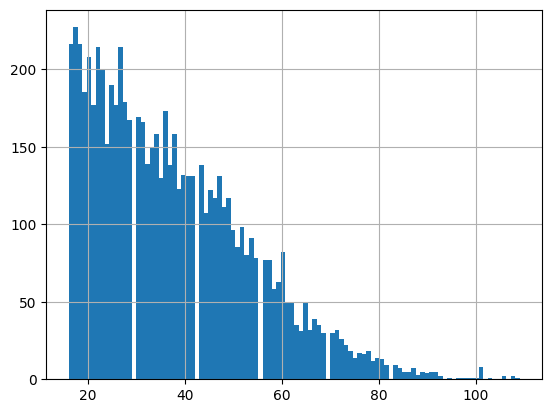

In [115]:
(sp192 > 0).sum(axis=1).hist(bins=100)